# Effect of 2 Harmonics on Extrema
The vanilla surface energy budget $C\frac{\partial T}{\partial t} = SW^{\downarrow} - \lambda T(t)$, if solved with a single harmonic of insolation has extrema phase set by $x = \tan \phi_0 = \frac{2\pi f C}{\lambda}$ and amplitude of $\frac{F_1}{\lambda}\frac{1}{\sqrt{1+x^2}}$.

This notebook looks at how going to 2 harmonics, and extending the form of the surface energy budget to $C\frac{d T}{dt} = F(t) - \Gamma(t)$ where:
$\Gamma(t) \approx \lambda_0 + \frac{1}{2}\lambda_{phase}(T'(t-\mathcal{T}/4) - T'(t+\mathcal{T}/4)) + \lambda T'(t) + \lambda_{sq}T'(t)^2 + \Lambda_{cos}\cos(4\pi t/\mathcal{T}) + \Lambda_{sin}\sin(4\pi t/\mathcal{T})$

affects both extrema, in a quantitative manner.

In [1]:
import copy
import sys
import os

from scipy.interpolate import CubicSpline

# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat, get_density, virtual_temp, saturation_vapor_pressure
from isca_tools.utils.constants import kappa, L_v, c_p, c_p_water, rho_water, Stefan_Boltzmann, R, R_v
from isca_tools.utils import area_weighting, annual_mean, annual_time_slice, anom_from_annual_mean, print_ds_var_list, numerical
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_temp_adiabat, get_temp_adiabat_surf
from isca_tools.convection.simple_betts_miller import lcl_temp, ref_temp_above_lcl, get_temp_ref
from isca_tools.convection import dry_profile_pressure, moist_profile, potential_temp
import isca_tools.utils.fourier as fourier
from isca_tools.utils.radiation import get_heat_capacity
from isca_tools.plot import colored_line
from isca_tools.thesis.surface_energy_budget import get_temp_fourier_analytic, get_temp_fourier_numerical, get_temp_extrema_analytic,\
    get_temp_extrema_numerical
from isca_tools.plot import label_subplots
from isca_tools.utils.calculus import grad_y
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from scipy.interpolate import CubicSpline
from tqdm.notebook import tqdm
from scipy import optimize, ndimage
import warnings
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
plt.rcParams['lines.linewidth'] = 0.8

In [36]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 't_surf', 'swdn_sfc', 'lwup_sfc', 'lwdn_sfc', 
            'flux_lhe', 'flux_t', 'drag_q', 'q_surf', 'rho', 'p_atm', 'ps', 'q_surf', 'ucomp', 'vcomp', 'w_atm']
# Load dataset

# # DEFAULT experiment
# exp_dir = 'tau_sweep/aquaplanet/'
# exp_name = [f"k={str(tau_lw[i]).replace('.','_')}" for i in range(n_exp)]

# # Experiment with no-WISHE and no convection
# exp_dir = 'aquaplanet/no_wishe/'
# exp_name = [f"k={str(tau_lw[i]).replace('.','_')}_no_conv" for i in range(n_exp)]

# exp_dir = 'aquaplanet/no_wishe/'
# exp_name = ["k=1"]

# exp_dir = 'aquaplanet/latent_heat_temp_only/'
# exp_name = ['evap=0_1']
exp_dir = 'aquaplanet/latent_heat_temp_only/depth=20/'
exp_name = ['base']


# Get low level sigma level
namelist = isca_tools.load_namelist(exp_dir+exp_name[0])
p_surface_approx = namelist['spectral_dynamics_nml']['reference_sea_level_press']/100
sigma_levels_half = np.asarray(namelist['vert_coordinate_nml']['bk'])
sigma_levels_full = np.convolve(sigma_levels_half, np.ones(2)/2, 'valid')
sigma_near_surf = sigma_levels_full[-1]

n_exp = len(exp_name)
lat_range = slice(30, 90)               # only consider NH and outside deep tropics, and ignore high latitudes as need 2nd harmonic there
use_time_start = 360*2
ds_base = []
for i in tqdm(range(n_exp)):
    ds_use = isca_tools.load_dataset(exp_dir + exp_name[i])
    try:
        ds_use = ds_use[var_keep]
    except KeyError:
        remove_keys = []
        for key in var_keep:
            if key not in ds_use:
                print(f'Removing {key} from var_keep')
                remove_keys += [key]
        for key in remove_keys:
            var_keep.remove(key)
        ds_use = ds_use[var_keep]
    ds_use = ds_use.sel(time=slice(use_time_start, np.inf)).sel(lat=lat_range)
    ds_use = ds_use.sel(pfull=np.inf, method='nearest')      # only keep lowest level
    # Compute variables required for flux breakdown
    ds_use['emission_factor'] = ds_use.lwdn_sfc/(Stefan_Boltzmann*ds_use.temp**4)
    ds_use['temp_diseqb'] = ds_use.t_surf - ds_use.temp
    ds_use['rh'] = ds_use.sphum / sphum_sat(ds_use.temp, ds_use.ps*sigma_near_surf)
    ds_use['lw_net'] = ds_use.lwup_sfc - ds_use.lwdn_sfc
    ds_base += [ds_use.load()]      # only keep after spin up
mixed_layer_depth = [isca_tools.load_namelist(exp_dir+exp_name[i])['mixed_layer_nml']['depth'] for i in range(n_exp)]

is_wishe=True
try:
    w_atm_const = isca_tools.load_namelist(exp_dir+exp_name[0])['surface_flux_nml']['w_atm_const']
    if w_atm_const > 0:
        is_wishe=False
        for i in range(n_exp):
            # Set wind to the constant value if it is set in namelist
            ds_base[i]['w_atm'] = ds_base[i]['w_atm']*0+w_atm_const
except KeyError:
    w_atm_const = np.nan

try: 
    rh_flux_q = isca_tools.load_namelist(exp_dir+exp_name[0])['surface_flux_nml']['rh_flux_q']
except KeyError:
    rh_flux_q = 0
try:
    evap_prefactor = isca_tools.load_namelist(exp_dir+exp_name[0])['surface_flux_nml']['land_evap_prefactor']
except KeyError:
    evap_prefactor = 1

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:52: UserWarning: First month saved is 121 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')


Removing height from var_keep


In [37]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
im_sz = 1.4     # larger makes images larger, keeping ar the same
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

In [38]:
def get_annual_zonal_mean(ds):
    ds_av = annual_mean(ds).mean(dim='lon')
    ds_av = ds_av.assign_coords(time=(ds_av.time - ds_av.time.min()).astype(int))
    return ds_av

In [39]:
ds = get_annual_zonal_mean(ds_base[0])
p_surface = float(ds.pfull)*100
if isinstance(w_atm_const, (int, float)):
    if w_atm_const == 0 or w_atm_const == np.nan:
        w_atm_const = ds.w_atm.mean(dim='time')

In [40]:
# Make every thing dependent on surface temperature (NOT NEAR-SURFACE) as equation easier to solve
# Link to near-surface with T_{s-a} term in latent flux etc
n_lat = ds.lat.size
n_time = ds.time.size
t_surf = ds.t_surf.to_numpy().transpose()
t_surf_anom = t_surf - np.mean(t_surf, axis=1)[:, np.newaxis]

## Obtaining extrema with no surface energy budget
Below, I obtain the times and amplitudes of the extrema directly on the simulated extrema, as well as on the direct Fourier fit of a given number of harmonics.

This direct fit is to give an estimate of the best we can reasonably expect to do from the given number of harmonics, once we have to find an analyitc expression for the temperature.

In [41]:
sw_amp_coefs = {key: np.zeros((n_lat, 1+int(key.replace('_harmonic', '')))) for key in ['1_harmonic', '2_harmonic', '5_harmonic']}
sw_fourier_fit = {key: np.zeros((n_lat, n_time)) for key in ['1_harmonic', '2_harmonic', '5_harmonic']}
temp_anom_fourier_fit = {key: np.zeros((n_lat, n_time)) for key in ['1_harmonic', '2_harmonic', '5_harmonic']}
for key in sw_amp_coefs:
    for i in range(n_lat):
        sw_amp_coefs[key][i] = fourier.get_fourier_fit(ds.time, ds.swdn_sfc[:, i], int(key.replace('_harmonic', '')))[1]
        # Fit SW fourier with no phase
        sw_fourier_fit[key][i] = fourier.fourier_series(ds.time, sw_amp_coefs[key][i], np.zeros(int(key.replace('_harmonic', ''))))
        temp_anom_fourier_fit[key][i] = fourier.get_fourier_fit(ds.time, t_surf_anom[i], int(key.replace('_harmonic', '')))[0]
    temp_anom_fourier_fit[key] = temp_anom_fourier_fit[key] - np.mean(temp_anom_fourier_fit[key], axis=1)[:, np.newaxis]
# Record phase of maxima / minima relative to extrema times of 1st harmonic of SW radiation 
time_extrema_sw = {'min': int(ds.time[0]), 'max': int(ds.time[int(ds.time.size/2)])}
smooth_ndays_temp_extrema = 20            # smoothing to temp annual mean to find date of hottest day

time_extrema_temp = {key: {key2: np.zeros(n_lat) for key2 in ['simulated', 'direct_fourier']} for key in ['min', 'max']}
amp_extrema_temp = {key: {key2: np.zeros(n_lat) for key2 in ['simulated', 'direct_fourier']} for key in ['min', 'max']}
for key in time_extrema_temp['min']:
    for i in range(n_lat):
        # No smoothing for '2_harmonic' as already fit smooth fourier solution
        time_extrema_temp['min'][key][i], time_extrema_temp['max'][key][i], amp_extrema_temp['min'][key][i], amp_extrema_temp['max'][key][i] = \
            get_temp_extrema_numerical(ds.time, t_surf_anom[i] if key=='simulated' else temp_anom_fourier_fit['2_harmonic'][i],
                                       smooth_ndays_temp_extrema if key=='simulated' else 1)

In [42]:
# General plotting info
heat_capacity = get_heat_capacity(c_p_water, rho_water, mixed_layer_depth[0])
plot_lat_approx = 85
plot_lat_ind = np.argmin(np.abs(ds.lat-plot_lat_approx).to_numpy())
month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])
ax_lims_time = [ds.time[0]-1, ds.time[-1]+1]
ax_lims_lat = [np.floor(ds.lat[0]), np.ceil(ds.lat[-1])]
color_approx = {'simulated': 'k', 'direct fit': 'k', 'linear': default_colors[0], 'square': default_colors[1], '1_harmonic': 'k',
                'lw': default_colors[3], 'lh': default_colors[1], 'sh': default_colors[2], 'linear_phase': default_colors[0], 
                'square_phase': default_colors[1], '6_order_phase': default_colors[3], 'square_phase_fourier': default_colors[1],
                '6_order_phase_fourier': default_colors[3]}
linestyle_approx = {'simulated': '-', 'direct fit': ':', 'linear': ':', '1_harmonic': ':', 'linear_phase': '--', 'linear_phase_0': '-', 
                    'square': ':', 'square_phase': '--', '6_order_phase': '--', 'square_phase_fourier': '-', '6_order_phase_fourier': '-'}
color_harmonic = {'1_harmonic': 'k', '2_harmonic': default_colors[1], '5_harmonic': default_colors[3]}
color_var = {'sum': 'k', 'w_atm': default_colors[2], 'drag_q': default_colors[1], 'rh': default_colors[0], 'temp_diseqb': default_colors[4], 
             'ps': default_colors[5], 'emission_factor': default_colors[0], 't_surf': default_colors[3]}
var_unit_labels = {'w_atm': '[ms$^{-1}$]', 'drag_q': None, 'rh': None, 'temp_diseqb': '[K]', 'ps': '[Pa]', 'emission_factor': None}

# Define error func to use
error_func_dict = {'max': lambda x, x_approx, norm=False, axis=1: np.max(np.abs(x - x_approx), axis=axis) / 
                                                                 (0.01*x.max(axis=axis)-0.01*x.min(axis=axis) if norm else 1), 
                   'median': lambda x, x_approx, norm=False, axis=1: np.median(np.abs(x - x_approx), axis=axis) / 
                                                                 (0.01*x.max(axis=axis)-0.01*x.min(axis=axis) if norm else 1), 
                   'mean': lambda x, x_approx, norm=False, axis=1: np.mean(np.abs(x - x_approx), axis=axis) / 
                                                                  (0.01*x.max(axis=axis)-0.01*x.min(axis=axis) if norm else 1)}
error_func_use = 'mean'
error_func = error_func_dict[error_func_use.lower()]

# Whether to show plots with smoothing of simulated values done or not. Theoretical curves always shown without smoothing
# Will also smooth simulated var but not approximated var before calculating error
# Fitting is always done with no smoothing performed first.
plot_smooth = True
if plot_smooth:
    smooth_func = lambda x, ax=-1: scipy.ndimage.convolve1d(x, np.ones(smooth_ndays_temp_extrema)/smooth_ndays_temp_extrema, mode='wrap', axis=ax)
else:
    smooth_func = lambda x, ax=0: x

resample = False        # whether to resample data so evenly spaced in x before finding polynomial coefficents.

## Gamma Fitting Parameters
The surface energy budget is of the form $C\frac{d T}{dt} = F(t) - \Gamma(t)$ where:
$\Gamma(t) \approx \lambda_0 + \frac{1}{2}\lambda_{phase}(T'(t-\mathcal{T}/4) - T'(t+\mathcal{T}/4)) + \lambda T'(t) + \lambda_{sq}T'(t)^2 + \sum_{n=2}^N (\Lambda_{n, cos}\cos(2n\pi t/\mathcal{T}) + \Lambda_{n, sin}\sin(2n\pi t/\mathcal{T}))$

Below we find the parameters required to estimate $\Gamma$ by empirically fitting to each component of the surface flux separately.

In [43]:
key = 'simulated'
gamma_comp_params = {key: {} for key in ['lw', 'lh', 'sh']}
gamma_comp = {key: {} for key in ['lw', 'lh', 'sh']}
gamma_comp['lw'][key] = (ds.lwup_sfc-ds.lwdn_sfc).transpose().to_numpy()
gamma_comp['lh'][key] = (ds.flux_lhe).transpose().to_numpy()
gamma_comp['sh'][key] = (ds.flux_t).transpose().to_numpy()
n_approx_params = {'linear': 2, 'square': 3, '6_order': 7, 'square_phase_fourier': 6}
for key in ['linear', 'square', '6_order']:
    n_approx_params[key+'_phase'] = n_approx_params[key]+1

gamma = {'simulated': np.asarray(ds.lwup_sfc - ds.lwdn_sfc + ds.flux_lhe + ds.flux_t).transpose()}
gamma_params = {}

# arg indices are: cos_param, sin_param, phase_param, square_param, linear_param, lambda_0
arg_ind = {'linear': [4, 5], 'linear_phase': [2, 4, 5], 'square': [3, 4, 5], 'square_phase': [2, 3, 4, 5], 'square_phase_fourier': np.arange(6)}

for key in ['linear', 'linear_phase', 'square', 'square_phase', 'square_phase_fourier']:
    for key2 in gamma_comp:
        gamma_comp_params[key2][key] = np.zeros((n_lat, n_approx_params['square_phase_fourier']))
        gamma_comp[key2][key] = np.zeros((n_lat, n_time))
        for i in range(n_lat):
            if 'fourier' in key:
                # Last 4 parameters are the normal polyfit_phase parameters
                gamma_comp_params[key2][key][i, 2:], param_fourier_amp_use, param_fourier_phase_use = \
                    numerical.polyfit_phase(t_surf_anom[i], gamma_comp[key2]['simulated'][i],
                                            n_approx_params[key.replace('_phase_fourier', '')] - 1, resample=resample,
                                            fourier_harmonics=np.asarray([2]))
                # first 2 parameters are fourier coefficients - convert to cos and sin coefficients so can add together
                gamma_comp_params[key2][key][i, :2] = fourier.coef_conversion(param_fourier_amp_use[2], param_fourier_phase_use[1])
                gamma_comp[key2][key][i] = numerical.polyval_phase(gamma_comp_params[key2][key][i, 2:], t_surf_anom[i],
                                                                   coefs_fourier_amp=param_fourier_amp_use, coefs_fourier_phase=param_fourier_phase_use)
            elif 'phase' in key:
                gamma_comp_params[key2][key][i, arg_ind[key]] = numerical.polyfit_phase(t_surf_anom[i], gamma_comp[key2]['simulated'][i],
                                                                          n_approx_params[key.replace('_phase', '')] - 1, resample=resample)
                gamma_comp[key2][key][i] = numerical.polyval_phase(gamma_comp_params[key2][key][i, arg_ind[key]], t_surf_anom[i])
            else:
                gamma_comp_params[key2][key][i, arg_ind[key]] = numerical.polyfit_phase(t_surf_anom[i], gamma_comp[key2]['simulated'][i],
                                                                          n_approx_params[key]-1, include_phase=False, resample=resample)[1:]
                gamma_comp[key2][key][i] = np.polyval(gamma_comp_params[key2][key][i, arg_ind[key]], t_surf_anom[i])

    gamma_params[key] = np.zeros((n_lat, n_approx_params['square_phase_fourier']))
    gamma[key] = np.zeros((n_lat, n_time))
    gamma_params[key] = gamma_comp_params['lw'][key]+gamma_comp_params['lh'][key]+gamma_comp_params['sh'][key]
    for i in range(n_lat):
        param_fourier_amp_use, param_fourier_phase_use = fourier.coef_conversion(cos_coef=gamma_params[key][i, 0], sin_coef=gamma_params[key][i, 1])
        param_fourier_amp_use = np.asarray([0, 0, param_fourier_amp_use])
        param_fourier_phase_use = np.asarray([0, param_fourier_phase_use])
        gamma[key][i] = numerical.polyval_phase(gamma_params[key][i, 2:], t_surf_anom[i],
                                                coefs_fourier_amp=param_fourier_amp_use, coefs_fourier_phase=param_fourier_phase_use)

## Interpretation of Parameters in $\Gamma$ approximation
The different parameters in the approximation for $\Gamma$ can be interpreted in terms of an effective heat capacity and feedback parameter experienced by each harmonic
i.e. $\frac{C_eff}{C} \neq 1$ and $\frac{\lambda_{eff}}{\lambda} \neq 1$.

Below, we do a sanity check that this interpretation matches the analytic solution. Note the effective heat capacity and $\lambda$ seen by each harmonic is different.

We do this interpretation for ease of algebraic manipulation later on. The reformulation neglects interaction between $\lambda_{sq}$ and $\lambda_{phase}$ which gives a slight error, but as shown below this is negligible - significantly less than 1 degree.

In [44]:
def get_single_harmonic_extrema(sw_amp1, heat_capacity, lambda_const, day_seconds=86400, n_days_year = 360):
    # Returns x, such that first extrema occurs at np.arctan(x)/(2pi freq) and amplitude of extrema of 1st harmonic
    # Both extrema have same amplitude and separated by half a period.
    f = 1/(n_days_year * day_seconds)
    x = 2*np.pi*f*heat_capacity / lambda_const
    amplitude = sw_amp1/lambda_const/np.sqrt(1+x**2)
    return x, np.abs(amplitude)

In [45]:
def get_effective_heat_capacity_lambda_scale(heat_capacity, lambda_const, lambda_phase=0, lambda_sq=0, lambda_cos=0,
                                             lambda_sin=0, sw_amp1=None, sw_amp2=None, n_days_year = 360, day_seconds=86400):
    # Get factors such that lambda_mod = lambda_scale * lambda and heat_capacity_mod = heat_capacity_scale * heat_capacity
    # Then with these modified factors, can use normal simple surface energy budget: C_mod * dT(t)/dt = F(t) - lambda_mod * T(t)
    f = 1/(n_days_year * day_seconds)
    if sw_amp1 is None:
        # If don't give insolation information, then return modification for parameters as seen by the 1st harmonic
        lambda_scale = 1
        heat_capacity_scale = 1 - lambda_phase / (2*np.pi*f*heat_capacity)
    else:
        # If have insolation information, return modification for parameters as seen by the 2nd harmonic
        x0 = 2*np.pi*f*heat_capacity / lambda_const
        sw_amp_eff = [sw_amp1, sw_amp2 - lambda_cos]

        sq_param = 0.5 * lambda_sq * sw_amp_eff[0]**2 / lambda_const**2 /(1+x0**2)**2
        mu = 1 - (sq_param*(1+4*x0**2) + lambda_sin*(2*x0+0.5/x0))/(sw_amp_eff[1] + sq_param*(5*x0**2-1) + lambda_sin*2*x0)
        lambda_scale = sw_amp_eff[1] * (1 + mu*4*x0**2) / (sw_amp_eff[1] + sq_param*(x0**2-1)) / (1 + mu**2*4*x0**2)

        heat_capacity_scale = mu * lambda_scale
    return lambda_scale, heat_capacity_scale


def get_effective_lambda_interpretation(time, sw_amp1, sw_amp2, heat_capacity, lambda_const, lambda_phase=0, lambda_sq=0, lambda_cos=0, lambda_sin=0,
                                        day_seconds=86400):
    f = 1/(time.size * day_seconds)
    sw_amp_eff = np.asarray([sw_amp1, sw_amp2 - lambda_cos])

    # Get effective parameters - allow different for each harmonic
    n_harmonics = 2
    lambda_mod = lambda_const * np.ones(n_harmonics)
    heat_capacity_mod = heat_capacity * np.ones(n_harmonics)

    # Phase - changes 1st harmonic only
    lambda_scale, heat_cap_scale = \
        get_effective_heat_capacity_lambda_scale(heat_capacity, lambda_const, lambda_phase, lambda_sq, lambda_cos, lambda_sin)
    lambda_mod[0] = lambda_mod[0] * lambda_scale
    heat_capacity_mod[0] = heat_capacity_mod[0] * heat_cap_scale
    # heat_capacity_mod[0] -= lambda_phase / (2*np.pi*f)

    lambda_scale, heat_cap_scale = \
        get_effective_heat_capacity_lambda_scale(heat_capacity, lambda_const, lambda_phase, lambda_sq, lambda_cos, lambda_sin,
                                                 sw_amp1, sw_amp2)
    lambda_mod[1] = lambda_mod[1] * lambda_scale
    heat_capacity_mod[1] = heat_capacity_mod[1] * heat_cap_scale

    x = 2*np.pi*f*heat_capacity_mod * np.arange(1, n_harmonics+1)/lambda_mod
    phase_coef = np.arctan(x)
    amp_coef = sw_amp_eff / lambda_mod / np.sqrt(1 + x ** 2)
    harmonic1 = fourier.fourier_series(time, [0, amp_coef[0], 0], [phase_coef[0], 0])
    harmonic2 = fourier.fourier_series(time, [0, 0, amp_coef[1]], [0, phase_coef[1]])
    return harmonic1, harmonic2, harmonic1 + harmonic2


In [46]:
# Get approximate temperature for each level in hierarchy of gamma approximation
temp_anom_analytic = {key: np.zeros((n_lat, n_time)) for key in ['linear', 'linear_phase', 'square', 'square_phase',
                                                                 'square_phase_fourier', 'linear_fourier', 'linear_phase_fourier',
                                                                 'square_fourier']}
gamma_params['linear_fourier'] = gamma_params['square_phase_fourier'] * [1, 1, 0, 0, 1, 1]
gamma_params['linear_phase_fourier'] = gamma_params['square_phase_fourier'] * [1, 1, 1, 0, 1, 1]
gamma_params['square_fourier'] = gamma_params['square_phase_fourier'] * [1, 1, 0, 1, 1, 1]
for key in temp_anom_analytic:
    for i in range(n_lat):
        temp_anom_analytic[key][i] = get_temp_fourier_analytic(ds.time.to_numpy(), ds.swdn_sfc.isel(lat=i).to_numpy(), heat_capacity,
                                                               gamma_params[key][i, 4], gamma_params[key][i, 2], gamma_params[key][i, 3],
                                                               gamma_params[key][i, 0], gamma_params[key][i, 1], n_harmonics_sw=2)[0]

[0.017937, 0.010509, 0.002594, 0.01, 0.009743, 0.003861, 0.004138, 0.016092, 0.03056, 0.039977, 0.039347, 0.030286, 0.020146, 0.011589, 0.006159, 0.003257, 0.000973, 0.005078, 0.007508, 0.006495, 0.004346]


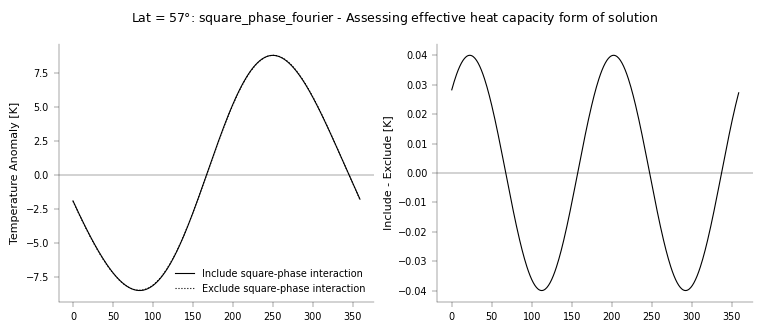

In [50]:
# Sanity check
key = 'square_phase_fourier'        # expect combination of square and phase to give slight error due to neglecting combined phase-square effects
                                    # all else should be 0
show_approx = False                 # Check linear taylor series version
var = []
var2 = []
for i in range(n_lat):
    var_use = get_effective_lambda_interpretation(ds.time.to_numpy(), sw_amp_coefs['2_harmonic'][i, 1],
                                                  sw_amp_coefs['2_harmonic'][i, 2], heat_capacity,
                                                  gamma_params[key][i, 4], lambda_phase=gamma_params[key][i, 2],
                                                  lambda_sq=gamma_params[key][i, 3],
                                                  lambda_cos=gamma_params[key][i, 0],
                                                  lambda_sin=gamma_params[key][i, 1])[-1]
    # Should be zero
    var += [np.round(np.abs(temp_anom_analytic[key][i]-var_use).max(), 6)]
print(var)
if np.max(var)>0:
    i = np.argmax(var)
    i = 9
    var_use = get_effective_lambda_interpretation(ds.time.to_numpy(), sw_amp_coefs['2_harmonic'][i, 1],
                                              sw_amp_coefs['2_harmonic'][i, 2], heat_capacity,
                                              gamma_params[key][i, 4], lambda_phase=gamma_params[key][i, 2],
                                              lambda_sq=gamma_params[key][i, 3],
                                              lambda_cos=gamma_params[key][i, 0],
                                              lambda_sin=gamma_params[key][i, 1])[-1]
    fig, ax = plt.subplots(1, 2, figsize=(2*im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
    ax[0].plot(ds.time, temp_anom_analytic[key][i], color='k', label='Include square-phase interaction')
    ax[0].plot(ds.time, var_use, color='k', linestyle=':', label='Exclude square-phase interaction')
    ax[1].plot(ds.time, temp_anom_analytic[key][i]-var_use, color='k')
    ax[0].legend()
    ax[0].set_ylabel('Temperature Anomaly [K]')
    ax[1].set_ylabel('Include - Exclude [K]')
    ax[0].axhline(0, color='k', lw=ax_linewidth)
    ax[1].axhline(0, color='k', lw=ax_linewidth)
    fig.suptitle(f'Lat = ${ds.lat[i]:.0f}\degree$: {key} - Assessing effective heat capacity form of solution', fontsize=9)

i## Expansion about maxima of 1st Harmonic
We want a simple equation which indicates how the 2nd harmonic shifts the extrema from that of the first harmonic. To do this, we expand about the time of th 1st maxima i.e. $t=t_{max1} + \Delta$, where $t_{max1} = \frac{\arctan(\frac{2\pi fC}{\lambda})}{2\pi f}$ is the maxima of the 1st harmonic for the simple linear surface energy budget of the form $C\frac{dT}{dt} = F(t) - \lambda T(t)$.

In shifting the time coordinate, we can write the 2 harmonic solution of temperature in the form:
$T(\Delta) = a_1 \cos(2\pi ft) + b_1 \sin(2\pi ft) + a_2 \cos(4\pi ft) + b_2 \sin(4\pi ft)$

where the $a_i$ and $b_i$ parameters include the $\lambda_{eff}$ and $C_{eff}$ modifications for the $i^{th}$ harmonic.

Below we do a sanity check that this coordinate shift is correct.

In [14]:
def get_shift_t_analytic_temp(time, sw_amp1, sw_amp2, heat_capacity, lambda_const, lambda_phase=0, lambda_sq=0, lambda_cos=0, lambda_sin=0,
                              harmonic_extrema_ind=1, day_seconds=86400, heat_cap_scale=None, lambda_scale=None):
    # Returns solution of form a_1cos(2 pi f t') + b_1sin(2 pi f t') + a_2cos(4 pi f t') + b_2sin(4 pi f t')
    # where t' = t - t_{max1} where t_{max1} is time of 1st harmonic extrema in case where lambda_phase=0, lambda_sq=0, lambda_cos=0, lambda_sin=0.
    # When considering the 2nd harmonic, a_1 and b_1 get multiplied by -1. This is the only change.
    f = 1/(time.size * day_seconds)
    sw_amp_eff = np.asarray([sw_amp1, sw_amp2 - lambda_cos])

    # Get effective parameters - allow different for each harmonic
    n_harmonics = 2
    if lambda_scale is None or heat_cap_scale is None:
        lambda_scale = np.ones(n_harmonics)      # lambda_mod = eta * lambda
        heat_cap_scale = np.ones(n_harmonics)   # heat_capacity_mod = heat_cap_scale * heat_capacity

        # 1st harmonic
        lambda_scale[0], heat_cap_scale[0] = \
            get_effective_heat_capacity_lambda_scale(heat_capacity, lambda_const, lambda_phase, lambda_sq, lambda_cos, lambda_sin)

        # 2nd harmonic
        lambda_scale[1], heat_cap_scale[1] = \
            get_effective_heat_capacity_lambda_scale(heat_capacity, lambda_const, lambda_phase, lambda_sq, lambda_cos, lambda_sin,
                                                     sw_amp1, sw_amp2)
    mu = heat_cap_scale / lambda_scale       # mu = (heat_capacity_mod / lambda_mod) / (heat_capacity/lambda) = heat_cap_scale / eta

    x = 2*np.pi*f*heat_capacity/lambda_const
    sq_param = 0.5 * lambda_sq * sw_amp_eff[0]**2 / lambda_const**2 /(1+x**2)**2

    a_1 = sw_amp_eff[0]/lambda_const * (1 + mu[0]*x**2)/np.sqrt((1+x**2)*(1+mu[0]**2*x**2)**2)
    b_1 = -sw_amp_eff[0]/lambda_const * x * (1-mu[0])/np.sqrt((1+x**2)*(1+mu[0]**2*x**2)**2)
    a_2 = 1/lambda_const * (sw_amp_eff[1] + sq_param*(x**2-1)) * (1-x**2+4*mu[1]*x**2) / (1+x**2) / (1+4*mu[1]*x**2)
    # a_2 = sw_amp_eff[0]/lambda_const/lambda_scale[1] * (sw_amp_eff[1]/sw_amp_eff[0]) * (1-x**2+4*mu[1]*x**2)/((1+x**2)*(1+4*mu[1]**2*x**2))
    # b_2 = sw_amp_eff[0]/lambda_const/lambda_scale[1] * (sw_amp_eff[1]/sw_amp_eff[0]) * (2*mu[1]*x*(1-x**2) - 2*x)/((1+x**2)*(1+4*mu[1]**2*x**2))
    b_2 = 1/lambda_const * -2*x * (sw_amp_eff[1] + sq_param*(x**2-1)) * (1+mu[1]*(x**2-1)) / (1+x**2) / (1+4*mu[1]*x**2)
    time_shift = time * day_seconds - np.arctan(x)/(2*np.pi*f)      # in seconds
    if harmonic_extrema_ind == 2:
        a_1 = -a_1
        b_1 = -b_1
        time_shift = time_shift - 1/(2*f)
    temp_analytic = a_1 * np.cos(2*np.pi*f*time_shift) + b_1 * np.sin(2*np.pi*f * time_shift) + a_2 * np.cos(4*np.pi*f * time_shift) + b_2 * np.sin(4*np.pi*f * time_shift)
    return temp_analytic, a_1, b_1, a_2, b_2, lambda_scale, heat_cap_scale

In [15]:
# Sanity check
key = 'square_phase_fourier'        # expect combination of square and phase to give slight error due to neglecting combined phase-square effects
                                    # all else should be 0
var = []
for i in range(n_lat):
    var_use = get_effective_lambda_interpretation(ds.time.to_numpy(), sw_amp_coefs['2_harmonic'][i, 1],
                                                  sw_amp_coefs['2_harmonic'][i, 2], heat_capacity,
                                                  gamma_params[key][i, 4], lambda_phase=gamma_params[key][i, 2],
                                                  lambda_sq=gamma_params[key][i, 3],
                                                  lambda_cos=gamma_params[key][i, 0],
                                                  lambda_sin=gamma_params[key][i, 1])
    # Check that shifting around maxima of 1st harmonic correct
    var_use2 = get_shift_t_analytic_temp(ds.time.to_numpy(), sw_amp_coefs['2_harmonic'][i, 1],
                                         sw_amp_coefs['2_harmonic'][i, 2], heat_capacity,
                                         gamma_params[key][i, 4], lambda_phase=gamma_params[key][i, 2],
                                         lambda_sq=gamma_params[key][i, 3],
                                         lambda_cos=gamma_params[key][i, 0],
                                         lambda_sin=gamma_params[key][i, 1], harmonic_extrema_ind=1)
    # Should be zero
    var += [np.round(np.abs(var_use2[0]-var_use[-1]).max(), 6)]
print(var)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


### Estimating Extrema at given latitude
If satisfying the surface energy budget, extrema occur where $\frac{\partial T}{\partial \Delta} = 0$, writing $y=\sin(2\pi f\Delta)$, this is where:

$f(y) = -a_1y + b\sqrt{1-y^2} - 4a_2 y \sqrt{1-y^2} + 2b_2 (1-2y^2)=0$

Below we look at how good an approximation this is for the extrema of $y$, compared to the simulated and direct fourier fit.

In [16]:
def get_extrema_theory(time, sw_amp1, sw_amp2, heat_capacity, lambda_const, lambda_phase=0, lambda_sq=0, lambda_cos=0, lambda_sin=0,
                       harmonic_extrema_ind=1, day_seconds=86400):
    # Returns function T(y) and dT_dt such that dT_dt(y)=0 gives values of extrema of y where y=sin(2pif\Delta) and time=t_extrema_1 + \Delta,
    # where t_extrema_1 is the time of the first harmonic extrema
    # T(y) is temperature evaluated at y=sin(2pif\Delta)
    # Also returns y corresponding to extrema and T evaluated at this y.
    a_1, b_1, a_2, b_2, lambda_scale, heat_cap_scale = get_shift_t_analytic_temp(time, sw_amp1, sw_amp2, heat_capacity, lambda_const,
                                                            lambda_phase, lambda_sq, lambda_cos, lambda_sin, harmonic_extrema_ind, day_seconds)[1:]
    # mu = heat_cap_scale / lambda_scale
    x, amplitude0 = get_single_harmonic_extrema(sw_amp1, heat_capacity, lambda_const, day_seconds, time.size)
    freq = 1/(time.size)       # frequency in day^{-1} units
    T_func = lambda y: a_1*np.sqrt(1-y**2) + b_1*y + a_2*(1-2*y**2) + 2*b_2*y*np.sqrt(1-y**2)
    dT_dt_func = lambda y: (-a_1*y + b_1*np.sqrt(1-y**2) - 4*a_2*y*np.sqrt(1-y**2) + 2*b_2*(1-2*y**2)) * 2 * np.pi * freq
    y_extrema = scipy.optimize.least_squares(dT_dt_func, 0, bounds=(-1, 1))['x'][0]
    return y_extrema, np.abs(T_func(y_extrema))/amplitude0, T_func, dT_dt_func

def get_extrema_theory_approx(time, sw_amp1, sw_amp2, heat_capacity, lambda_const, lambda_phase=0, lambda_sq=0, lambda_cos=0, lambda_sin=0,
                              harmonic_extrema_ind=1, approx='linear', day_seconds=86400):
    info_param = {'sw': sw_amp2 / sw_amp1, 'phase': lambda_phase/lambda_const, 'sq': lambda_sq / lambda_const**2 * sw_amp1,
                  'cos': lambda_cos / sw_amp1, 'sin': lambda_sin / sw_amp1}
    if harmonic_extrema_ind==1:
        sign_use = -1
    else:
        sign_use = 1
    x, amplitude0 = get_single_harmonic_extrema(sw_amp1, heat_capacity, lambda_const, day_seconds, time.size)
    info_coef_y = {'sw': sign_use / (x**2+1)**0.5 / (4*x**2+1) * 4*x**3,
                 'sw_square': 16*x**3*(3*x**2+1) / (x**2+1) / (4*x**2+1)**2,
                 'sw_cube': sign_use * 64/(x**2+1)**1.5/(1+4*x**2)**3 * (x**3*(3*x**2+1)**2 - 2*x**9),
                 'phase': -1/(x**2+1),
                 'phase_square': -x/(x**2+1)**2,
                 'sq': sign_use / (x**2+1)**0.5 / (4*x**2+1) * 2*x,
                 'sin': sign_use / (x**2+1)**0.5 / (4*x**2+1) * 2*(3*x**2+1),
                 'sw_phase': -sign_use * 4 / (x**2+1)**2 / (4*x**2+1) * (x**4*(x**2+1)**0.5 + 3*x**2+1),
                 'sw_sq': 8*x*(2*x**2+1) / (x**2+1) / (4*x**2+1)**2,
                 'sw_sin': 2*((3*x**2+1)**2-4*x**6) / (x**2+1) / (4*x**2+1)**2}
    info_coef_y['cos'] = -info_coef_y['sw']
    info_coef_y['cos_square'] = info_coef_y['sw_square']
    info_coef_y['sw_cos'] = -2*info_coef_y['sw_square']

    info_cont_y = {key: info_coef_y[key] * info_param[key] for key in info_param}
    info_cont_y['sw_square'] = info_coef_y['sw_square'] * info_param['sw']**2
    info_cont_y['sw_residual'] = get_extrema_theory(time, sw_amp1, sw_amp2, heat_capacity, lambda_const, 0, 0, 0, 0,
                                                    harmonic_extrema_ind, day_seconds)[0] - info_cont_y['sw'] - info_cont_y['sw_square']
    info_cont_y['phase_square'] = info_coef_y['phase_square'] * info_param['phase'] **2
    info_cont_y['cos_square'] = info_coef_y['cos_square'] * info_param['cos'] **2
    info_cont_y['sw_phase'] = info_coef_y['sw_phase'] * info_param['sw'] * info_param['phase']
    info_cont_y['sw_sq'] = info_coef_y['sw_sq'] * info_param['sw'] * info_param['sq']
    info_cont_y['sw_cos'] = info_coef_y['sw_cos'] * info_param['sw'] * info_param['cos']
    info_cont_y['sw_sin'] = info_coef_y['sw_sin'] * info_param['sw'] * info_param['sin']

    info_coef_amp = {'sw': -sign_use * (3*x**2+1) / (x**2+1)**0.5 / (4*x**2+1),
                     'sw_square': 8*x**6 / (x**2+1) / (4*x**2+1)**2,
                     'phase': x/(x**2+1),
                     'phase_square': (x**2-0.5) / (x**2+1)**2,
                     'sq': sign_use / 2 / (x**2+1)**0.5 / (4*x**2+1),
                     'sin': sign_use * 2*x**3 / (x**2+1)**0.5 / (4*x**2+1),
                     'sw_phase': -sign_use * 4*x**3 / (x**2+1)**2 / (4*x**2+1),
                     'sw_sq': 8*x**4 / (x**2+1) / (4*x**2+1)**2,
                     'sw_sin': 8*x**3 * (3*x**2+1) / (x**2+1) / (4*x**2+1)**2,
                     }
    info_coef_amp['cos'] = -info_coef_amp['sw']
    info_coef_amp['cos_square'] = info_coef_amp['sw_square']
    info_coef_amp['sw_cos'] = -2*info_coef_amp['sw_square']

    info_cont_amp = {key: info_coef_amp[key] * info_param[key] for key in info_param}
    info_cont_amp['sw_square'] = info_coef_amp['sw_square'] * info_param['sw']**2
    info_cont_amp['sw_residual'] = get_extrema_theory(time, sw_amp1, sw_amp2, heat_capacity, lambda_const, 0, 0, 0, 0,
                                                  harmonic_extrema_ind, day_seconds)[1] - 1 - info_cont_amp['sw'] - info_cont_amp['sw_square']
    info_cont_amp['phase_square'] = info_coef_amp['phase_square'] * info_param['phase'] **2
    info_cont_amp['cos_square'] = info_coef_amp['cos_square'] * info_param['cos'] **2
    info_cont_amp['sw_phase'] = info_coef_amp['sw_phase'] * info_param['sw'] * info_param['phase']
    info_cont_amp['sw_sq'] = info_coef_amp['sw_sq'] * info_param['sw'] * info_param['sq']
    info_cont_amp['sw_cos'] = info_coef_amp['sw_cos'] * info_param['sw'] * info_param['cos']
    info_cont_amp['sw_sin'] = info_coef_amp['sw_sin'] * info_param['sw'] * info_param['sin']

    keys_use = [key for key in info_param]
    if 'sw_exact' in approx:
        keys_use += ['sw_square', 'sw_residual']
    elif 'square' in approx:
        keys_use += ['sw_square', 'phase_square', 'cos_square']
    if 'non_linear' in approx:
        for key in ['sw_phase', 'sw_sq', 'sw_sin', 'sw_square', 'phase_square', 'cos_square']:
            if key not in keys_use:
                keys_use += [key]
    y_cont_use = {key: info_cont_y[key] for key in keys_use}
    amp_cont_use = {key: info_cont_amp[key] for key in keys_use}
    return sum(y_cont_use.values()), 1+sum(amp_cont_use.values()), info_param, info_coef_y, info_cont_y, info_coef_amp, info_cont_amp

In [17]:
def get_y(time, heat_capacity, lambda_const, extrema_ind=1, day_seconds=86400, n_days_year=360):
    # Returns y=sin(2\pi f\Delta) where \Delta=t_extrema - t_extrema_1
    # I.e. the time relative to first harmonic
    f = 1/(n_days_year * day_seconds)
    x = 2*np.pi*f*heat_capacity/lambda_const
    time_harmonic1 = np.arctan(x)/(2*np.pi*f)
    if extrema_ind == 2:
        time_harmonic1 = time_harmonic1 + 1/(2*f)
    time_shift = time * day_seconds - time_harmonic1
    y = np.sin(2*np.pi*f*time_shift)
    # temp_spline = CubicSpline(np.append(time, time[-1]+1), np.append(temp, temp[0]), bc_type='periodic')
    return y

def get_phase_amp_relative_harmonic1(time_extrema, temp_extrema, sw_amp1, heat_capacity, lambda_const,
                                     extrema_ind=1, day_seconds=86400, n_days_year=360):
    # Returns y=sin(2\pi f\Delta) where \Delta=t_extrema - t_extrema_1 and A=T_extrema/T_extrema_1
    # I.e. the time and amplitude of extrema relative to first harmonic
    f = 1/(n_days_year * day_seconds)
    x = 2*np.pi*f*heat_capacity/lambda_const
    y = get_y(time_extrema, heat_capacity, lambda_const, extrema_ind, day_seconds, n_days_year)
    amp_harmonic1 = np.abs(sw_amp1/lambda_const/np.sqrt(1+x**2))
    return y, temp_extrema/amp_harmonic1

def sort_arrays_by_first(arr1, arr2):
    # Combine arr1 and arr2 into tuples
    combined = list(zip(arr1, arr2))

    # Sort the combined list based on arr1 (the first element of each tuple)
    sorted_combined = sorted(combined, key=lambda x: x[0])

    # Extract sorted arrays from sorted_combined
    sorted_arr1 = [item[0] for item in sorted_combined]
    sorted_arr2 = [item[1] for item in sorted_combined]

    return sorted_arr1, sorted_arr2

In [18]:
y_extrema = {key: {key2: np.zeros((n_lat, 2)) for key2 in ['simulated', 'direct_fourier', 'theory_full', 'approx']} for key in gamma_params}
amp_scale_extrema = {key: {key2: np.zeros((n_lat, 2)) for key2 in y_extrema['linear']} for key in gamma_params}
for key in y_extrema:
    for key2 in y_extrema['linear']:
        for i in range(n_lat):
            for j in range(2):
                if key2 == 'simulated' or key2 == 'direct_fourier':
                    y_extrema[key][key2][i, j], amp_scale_extrema[key][key2][i, j] = \
                        get_phase_amp_relative_harmonic1(time_extrema_temp['min' if j==0 else 'max'][key2][i],
                                                         amp_extrema_temp['min' if j==0 else 'max'][key2][i],
                                                         sw_amp_coefs['2_harmonic'][i, 1], heat_capacity, gamma_params[key][i, 4], j+1)
                elif key2 == 'theory_full':
                    y_extrema[key][key2][i, j], amp_scale_extrema[key][key2][i, j] = \
                        get_extrema_theory(ds.time.to_numpy(), sw_amp_coefs['2_harmonic'][i, 1],
                                         sw_amp_coefs['2_harmonic'][i, 2], heat_capacity, gamma_params[key][i, 4], lambda_phase=gamma_params[key][i, 2],
                                         lambda_sq=gamma_params[key][i, 3], lambda_cos=gamma_params[key][i, 0], lambda_sin=gamma_params[key][i, 1],
                                         harmonic_extrema_ind=j+1)[:2]
                elif key2 == 'approx':
                    y_extrema[key][key2][i, j], amp_scale_extrema[key][key2][i, j] = \
                        get_extrema_theory_approx(ds.time.to_numpy(), sw_amp_coefs['2_harmonic'][i, 1],
                                         sw_amp_coefs['2_harmonic'][i, 2], heat_capacity, gamma_params[key][i, 4], lambda_phase=gamma_params[key][i, 2],
                                         lambda_sq=gamma_params[key][i, 3], lambda_cos=gamma_params[key][i, 0], lambda_sin=gamma_params[key][i, 1],
                                         harmonic_extrema_ind=j+1, approx='square')[:2] # only keep square terms as approx - hard to interpret non-linear

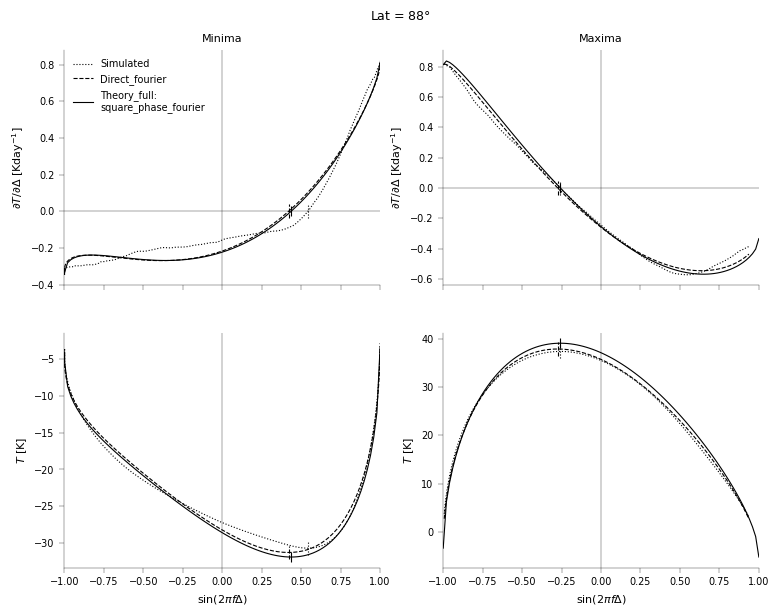

In [19]:
y_plot = np.linspace(-1, 1, 100)
plot_extrema_label = ['Minima', 'Maxima']
color_extrema = {'simulated': 'k', 'direct_fourier': 'k', 'theory_full': 'k', 'linear': default_colors[0], 'square': default_colors[1],
                 'sw_exact': default_colors[3], 'sw_exact_non_linear': default_colors[2], 'non_linear': default_colors[4],
                 'approx': default_colors[0]}
linestyle_extrema = {'simulated': ':', 'direct_fourier': '--',  'theory_full': None, 'linear': None, 'square': None, 'sw_exact': None,
                     'sw_exact_non_linear': None, 'non_linear': None, 'approx': None}

key = 'square_phase_fourier'
plot_lat_ind=-1
fig, ax = plt.subplots(2, 2, figsize=(im_sz*2*width['one_col'], 2*im_sz*width['one_col']/ar), sharex=True)
var = -get_single_harmonic_extrema(sw_amp_coefs['2_harmonic'][plot_lat_ind, 1], heat_capacity, gamma_params[key][plot_lat_ind, 4])[1]
for i in range(1, 3):
    # Plot simulated and direct fourier stuff
    spline_y = get_y(ds.time.to_numpy(), heat_capacity, gamma_params[key][plot_lat_ind, 4], i)
    if i == 2:
        use_ind = t_surf_anom[plot_lat_ind]>np.abs(var)/10
        var = -1 * var
    else:
        use_ind = t_surf_anom[plot_lat_ind]<-np.abs(var)/10
    for key2 in ['simulated', 'direct_fourier']:
        if key2 == 'simulated':
            # use smoothed temp as use smoothed temp to find simulated extrema in time_extrema_temp
            spline_temp = CubicSpline(np.append(ds.time, ds.time[-1]+1), np.append(smooth_func(t_surf_anom[plot_lat_ind]),
                                                                                   smooth_func(t_surf_anom[plot_lat_ind])[0]), bc_type='periodic')
        else:
            spline_temp = CubicSpline(np.append(ds.time, ds.time[-1]+1),
                                      np.append(temp_anom_fourier_fit['2_harmonic'][plot_lat_ind], temp_anom_fourier_fit['2_harmonic'][plot_lat_ind][0]),
                                      bc_type='periodic')
        var2 = sort_arrays_by_first(spline_y[use_ind], spline_temp.derivative()(ds.time)[use_ind])
        ax[0, i-1].plot(var2[0], var2[1], color=color_extrema[key2], linestyle=linestyle_extrema[key2], label=key2.capitalize())
        ax[0, i-1].scatter(y_extrema[key][key2][plot_lat_ind, i-1], 0, linestyle=linestyle_extrema[key2], color=color_extrema[key2],
                           marker='|', s=100)
        var2 = sort_arrays_by_first(spline_y[use_ind], spline_temp(ds.time)[use_ind])
        ax[1, i-1].plot(var2[0], var2[1], color='k', linestyle=linestyle_extrema[key2])
        ax[1, i-1].scatter(y_extrema[key][key2][plot_lat_ind, i-1],
                           amp_scale_extrema[key][key2][plot_lat_ind, i-1] * var, linestyle=linestyle_extrema[key2], color=color_extrema[key2], marker='|', s=100)


    # for key2 in ['theory_full', 'approx_linear', 'approx_square', 'approx_sw_exact']:
    for key2 in ['theory_full']:
        if 'full' in key2:
            func_use = get_extrema_theory(ds.time.to_numpy(), sw_amp_coefs['2_harmonic'][plot_lat_ind, 1],
                            sw_amp_coefs['2_harmonic'][plot_lat_ind, 2], heat_capacity,
                            gamma_params[key][plot_lat_ind, 4], lambda_phase=gamma_params[key][plot_lat_ind, 2],
                            lambda_sq=gamma_params[key][plot_lat_ind, 3],
                            lambda_cos=gamma_params[key][plot_lat_ind, 0],
                            lambda_sin=gamma_params[key][plot_lat_ind, 1],
                            harmonic_extrema_ind=i)[2:]
            ax[0, i-1].plot(y_plot, func_use[1](y_plot), color=color_extrema[key2],
                            label=key2.capitalize() + (':\n' + key if key2=='theory_full' else ''))
            ax[1, i-1].plot(y_plot, func_use[0](y_plot), color=color_extrema[key2])
        ax[0, i-1].scatter(y_extrema[key][key2][plot_lat_ind, i-1], 0, color=color_extrema[key2.replace('approx_', '')], marker='|', s=50)
        ax[1, i-1].scatter(y_extrema[key][key2][plot_lat_ind, i-1], amp_scale_extrema[key][key2][plot_lat_ind, i-1] * var,
                           color=color_extrema[key2.replace('approx_', '')], marker='|', s=50)
    ax[0, i-1].set_ylabel('$\partial T/\partial \Delta$ [Kday$^{-1}$]')
    ax[1, i-1].set_ylabel('$T$ [K]')
    ax[0, i-1].axhline(0, color='k', lw=ax_linewidth)
    ax[0, i-1].set_title(plot_extrema_label[i-1])


for ax_use in ax.flatten():
    ax_use.axvline(0, color='k', lw=ax_linewidth)
ax[0, 0].legend()
ax[1, 0].set_xlabel('$\sin(2\pi f \Delta)$')
ax[1, 1].set_xlabel('$\sin(2\pi f \Delta)$')
ax[1, 1].set_xlim(-1, 1)

# ax[0, 1].set_ylabel('$\sin(2\pi f \Delta_{extrema})$')
fig.suptitle(f"Lat = ${ds.lat[plot_lat_ind]:.0f}\degree$", fontsize=9, y=0.94)
plt.show()

### Extrema as function of latitude
Interestingly, even the theory_full line shows a significant deviation to the simulated value. In particular, the phase and amplitude of the maxima are over-estimated.

This is because we are constraining ourselves to two harmonics, and as shown by the closeness of the theory (obeying a surface energy budget) to the direct Fourier fit (not obeying surface energy budget but fit with 2 harmonics) - it is doing almost as well as a 2 harmonic solution can do.

The remaining discrepancy arises in the high latitude of amplitude, and probably arises because we assume $T^2$ is dominated by the first harmonic, but at high latitudes, the second harmonic is significant.

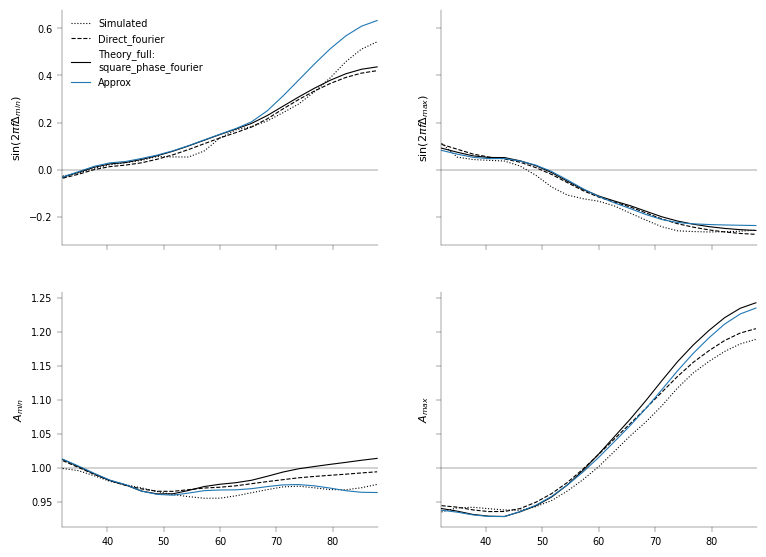

In [20]:
key = 'square_phase_fourier'
fig, ax = plt.subplots(2, 2, figsize=(im_sz*2*width['one_col'], 2*im_sz*width['one_col']/ar), sharex=True, sharey='row')
for i in range(1, 3):
    for key2 in ['simulated', 'direct_fourier', 'theory_full', 'approx']:
        ax[0, i-1].plot(ds.lat, y_extrema[key][key2][:, i-1], color=color_extrema[key2],
                        linestyle=linestyle_extrema[key2],
                        label=key2.capitalize() + (':\n' + key if key2=='theory_full' else ''))
        ax[1, i-1].plot(ds.lat, amp_scale_extrema[key][key2][:, i-1], color=color_extrema[key2],
                        linestyle=linestyle_extrema[key2])
    ax[0, i-1].axhline(0, color='k', lw=ax_linewidth)
    ax[1, i-1].axhline(1, color='k', lw=ax_linewidth)
ax[0, 0].legend()
ax[0, 0].set_xlim(ax_lims_lat)
ax[0, 0].set_ylabel('$\sin(2\pi f \Delta_{min})$')
ax[0, 1].set_ylabel('$\sin(2\pi f \Delta_{max})$')
ax[1, 0].set_ylabel('$A_{min}$')
ax[1, 1].set_ylabel('$A_{max}$')
plt.show()

## Sanity check of best fitting method
Below, I plot the difference between the full theory (2 harmonics, satisfying surface energy budget) and direct fourier 2 harmonic fit for each extrema amplitude and phase. Clearly the error is smallest for the square_phase_fourier method.

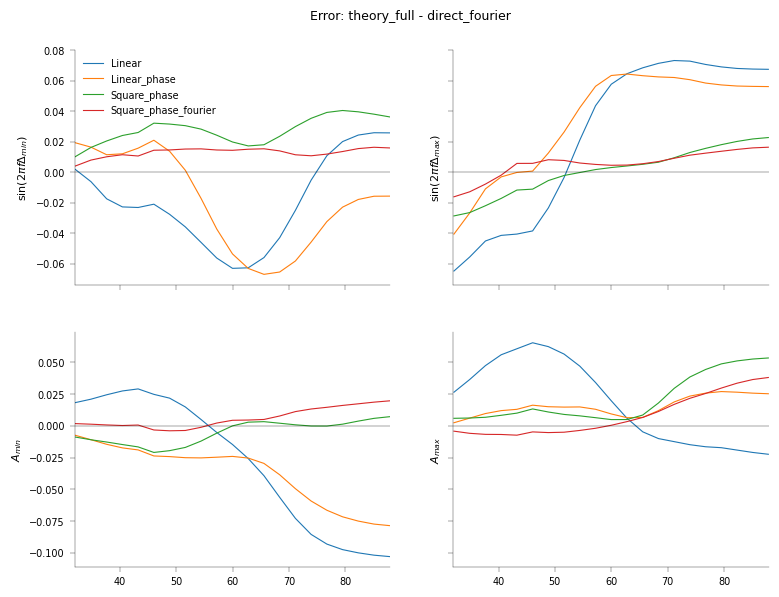

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(im_sz*2*width['one_col'], 2*im_sz*width['one_col']/ar), sharex=True, sharey='row')
for i in range(1, 3):
    for key in ['linear', 'linear_phase', 'square_phase', 'square_phase_fourier']:
        ax[0, i-1].plot(ds.lat, y_extrema[key]['theory_full'][:, i-1]-y_extrema[key]['direct_fourier'][:, i-1],
                        label=key.capitalize())
        ax[1, i-1].plot(ds.lat, amp_scale_extrema[key]['theory_full'][:, i-1]-amp_scale_extrema[key]['direct_fourier'][:, i-1])
    ax[0, i-1].axhline(0, color='k', lw=ax_linewidth)
    ax[1, i-1].axhline(0, color='k', lw=ax_linewidth)
ax[0, 0].legend()
ax[0, 0].set_xlim(ax_lims_lat)
ax[0, 0].set_ylabel('$\sin(2\pi f \Delta_{min})$')
ax[0, 1].set_ylabel('$\sin(2\pi f \Delta_{max})$')
ax[1, 0].set_ylabel('$A_{min}$')
ax[1, 1].set_ylabel('$A_{max}$')
fig.suptitle('Error: theory_full - direct_fourier', fontsize=9, y=0.94)
plt.show()

## Parameter Influence on Extrema Date and Amplitude
Below we look at how the different parameters influence the extrema.

### Variation of parameters with latitude
There are 5 parameters which affect the deviation of the extrema from that of the 1st harmonic. Below we look at how the non-dimensional form of each parameter varies with latitude.

In [22]:
heat_capacity_scale = {key: np.ones((n_lat, 2)) for key in gamma_params}
lambda_scale = {key: np.ones((n_lat, 2)) for key in gamma_params}
for key in heat_capacity_scale:
    for i in range(n_lat):
        lambda_scale[key][i], heat_capacity_scale[key][i] = get_shift_t_analytic_temp(ds.time.to_numpy(), sw_amp_coefs['2_harmonic'][i, 1],
                                             sw_amp_coefs['2_harmonic'][i, 2], heat_capacity,
                                             gamma_params[key][i, 4], lambda_phase=gamma_params[key][i, 2],
                                             lambda_sq=gamma_params[key][i, 3],
                                             lambda_cos=gamma_params[key][i, 0],
                                             lambda_sin=gamma_params[key][i, 1])[-2:]

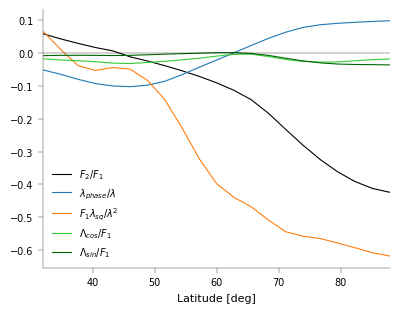

In [23]:
key = 'square_phase_fourier'
color_param = {'cos': 'limegreen', 'sin': 'darkgreen', 'phase': default_colors[0], 'sq': default_colors[1], 'sw': 'k'}
labels_param = {'cos': '$\Lambda_{cos}/F_1$', 'sin': '$\Lambda_{sin}/F_1$', 'sw': '$F_2/F_1$', 'phase': '$\lambda_{phase}/\lambda$',
                'sq': '$F_1\lambda_{sq}/\lambda^2$'}
fig, ax = plt.subplots(1, 1, figsize=(im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
ax.plot(ds.lat, sw_amp_coefs['2_harmonic'][:, 2]/sw_amp_coefs['2_harmonic'][:, 1], color=color_param['sw'], label='$F_2/F_1$')
ax.plot(ds.lat, gamma_params[key][:, 2]/gamma_params[key][:, 4], color=color_param['phase'], label='$\lambda_{phase}/\lambda$')
ax.plot(ds.lat, gamma_params[key][:, 3]/gamma_params[key][:, 4]**2 * sw_amp_coefs['2_harmonic'][:, 1],
        color=color_param['sq'], label='$F_1\lambda_{sq}/\lambda^2$')
ax.plot(ds.lat, gamma_params[key][:, 0]/sw_amp_coefs['2_harmonic'][:, 1], color=color_param['cos'], label='$\Lambda_{cos}/F_1$')
ax.plot(ds.lat, gamma_params[key][:, 1]/sw_amp_coefs['2_harmonic'][:, 1], color=color_param['sin'], label='$\Lambda_{sin}/F_1$')
ax.legend()
ax.axhline(0, color='k', lw=ax_linewidth)
ax.set_xlim(ax_lims_lat)
ax.set_xlabel('Latitude [deg]')
plt.show()

## Isolating Effect of each Parameter
Below, we isolate the effect of each parameter by setting each to 0 individually, while leaving the others at their actual value. We see that we need the squared and higher order terms to capture the variation (in time especially) due to $F_2/F_1$. Whereas for the other parameters, the linear approximation is pretty good.

In [24]:
def heat_capacity_from_date(date, lambda_const, n_days_year=360, day_seconds=86400):
    # Given date of 1st harmonic in units of days, returns corresponding heat capacity
    return np.tan(date * (2*np.pi/n_days_year)) * lambda_const * n_days_year * day_seconds / 2 / np.pi

def date_from_heat_capacity(heat_capacity, lambda_const, n_days_year=360, day_seconds=86400):
    # Given heat capacity, will return date of 1st harmonic in units of days
    return np.arctan(2*np.pi * heat_capacity / lambda_const / n_days_year / day_seconds) / (2*np.pi/n_days_year)

In [25]:
plot_const_val = {}
plot_const_val['heat_capacity'] = get_heat_capacity(c_p_water, rho_water, layer_depth=5)
plot_const_val['lambda'] = 3
plot_const_val['F_1'] = -140
plot_const_val['sw'] = 1e-10    # small but non-zero, otherwise get divide by zero error
plot_const_val['phase'] = 0
plot_const_val['sq'] = 0
plot_const_val['cos'] = 0
plot_const_val['sin'] = 0
n_range_val = 21
plot_range_val = {'sw': np.linspace(-0.43, 0.43, n_range_val),
                  'phase': np.linspace(-0.8, 0.8, n_range_val),
                  'sq': np.linspace(-0.7, 0.7, n_range_val),
                  'cos': np.linspace(-0.05, 0.05, n_range_val),
                  'sin': np.linspace(-0.05, 0.05, n_range_val)}

extrema_time_range = {key: np.zeros((2, n_range_val)) for key in plot_range_val}
extrema_amp_range= {key: np.zeros((2, n_range_val)) for key in extrema_time_range}


for k in range(2):
    for i in range(n_range_val):
        for key2 in extrema_time_range:
            extrema_time_range[key2][k, i], extrema_amp_range[key2][k, i] = \
                get_extrema_theory(ds.time.to_numpy(), plot_const_val['F_1'],
                                   plot_const_val['F_1'] * (plot_range_val['sw'][i] if 'sw' in key2 else plot_const_val['sw']),
                                   plot_const_val['heat_capacity'], plot_const_val['lambda'],
                                   (plot_range_val['phase'][i] if 'phase' in key2 else plot_const_val['phase']) * plot_const_val['lambda'],
                                   (plot_range_val['sq'][i] if 'sq' in key2 else plot_const_val['sq']) *
                                   plot_const_val['lambda']**2 / plot_const_val['F_1'],
                                   (plot_range_val['cos'][i] if 'cos' in key2 else plot_const_val['cos']) * plot_const_val['F_1'],
                                   (plot_range_val['sin'][i] if 'sin' in key2 else plot_const_val['sin']) * plot_const_val['F_1'],
                                   harmonic_extrema_ind=k+1)[:2]

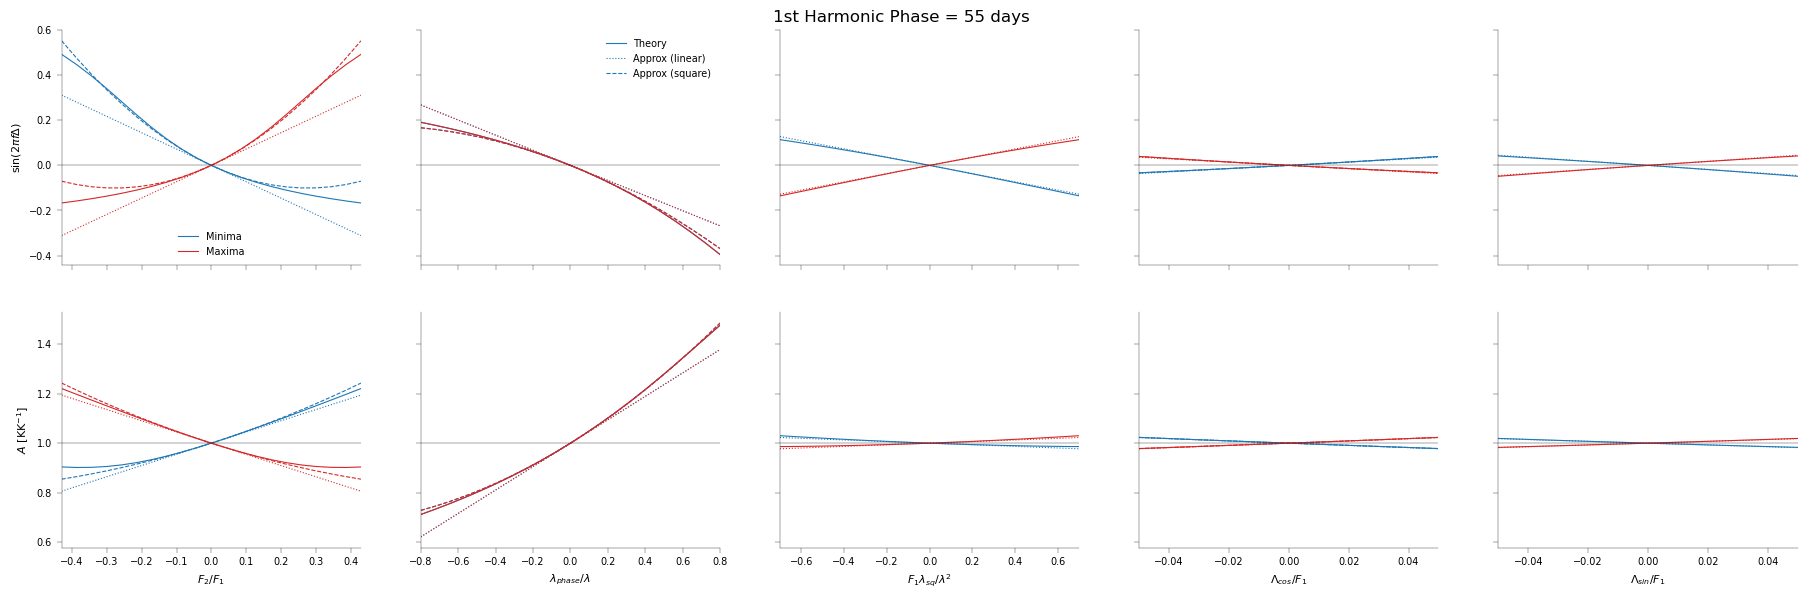

In [26]:
color_min_max = [default_colors[0], default_colors[3]]
taylor_coefs = [get_extrema_theory_approx(ds.time.to_numpy(), plot_const_val['F_1'], plot_const_val['sw'], plot_const_val['heat_capacity'],
                          plot_const_val['lambda'], 0, 0, 0, 0, harmonic_extrema_ind=k+1)[-4::2] for k in range(2)]
fig, ax = plt.subplots(2, 5, figsize=(5*im_sz*width['one_col'], 2*im_sz*width['one_col']/ar), sharey='row', sharex='col')
for i, key2 in enumerate(['sw', 'phase', 'sq', 'cos', 'sin']):
    for k in range(2):
        coef_use = [taylor_coefs[k][0][key2], taylor_coefs[k][1][key2]]
        ax[0, i].plot(plot_range_val[key2], extrema_time_range[key2][k], color=color_min_max[k], label=plot_extrema_label[k] if i==0 else
        ('Theory' if k==0 and i==1 else None))
        ax[1, i].plot(plot_range_val[key2], extrema_amp_range[key2][k], color=color_min_max[k], label=plot_extrema_label[k] if i==0 else None)
        ax[0, i].plot(plot_range_val[key2], plot_range_val[key2] * coef_use[0], color=color_min_max[k], linestyle=':',
                      label='Approx (linear)' if k==0 and i==1 else None)
        ax[1, i].plot(plot_range_val[key2], 1+plot_range_val[key2] * coef_use[1], color=color_min_max[k], linestyle=':')
        if key2 in ['sw', 'phase', 'cos']:
            ax[0, i].plot(plot_range_val[key2], plot_range_val[key2] * taylor_coefs[k][0][key2] +
                          plot_range_val[key2]**2 * taylor_coefs[k][0][f'{key2}_square'], color=color_min_max[k], linestyle='--',
                          label='Approx (square)' if k==0 and i==1 else None)
            ax[1, i].plot(plot_range_val[key2], 1+plot_range_val[key2] * taylor_coefs[k][1][key2] +
                          plot_range_val[key2]**2 * taylor_coefs[k][1][f'{key2}_square'], color=color_min_max[k], linestyle='--')
    ax[0, i].axhline(0, color='k', lw=ax_linewidth)
    ax[1, i].axhline(1, color='k', lw=ax_linewidth)
    ax[1, i].set_xlabel(labels_param[key2])
    ax[0, i].set_xlim(plot_range_val[key2][0], plot_range_val[key2][-1])
ax[0, 0].legend()
ax[0, 1].legend()
ax[0, 0].set_ylabel(f'$\sin(2\pi f\Delta)$')
ax[1, 0].set_ylabel('$A$ [KK$^{-1}$]')
fig.suptitle("1st Harmonic Phase = {:.0f} days".format(date_from_heat_capacity(plot_const_val['heat_capacity'], plot_const_val['lambda'])), y=0.91)
plt.show()

### Error due to approximation of $F_2/F_1$
Above, we saw that at high latitudes (large negative $F_2/F_1$), the time and amplitude of extrema differ from the estimate including the linear and square terms in the taylor expansion.

Below, we look at how this error depends on $F_2/F_1$ and $x=2\pi fC/\lambda$, with $x$ put into the units of days - larger value means larger heat capacity, and 1st harmonic extrema occur later in the year.

We see that the error is greatest with small $x$ and large $F_2/F_1$ - similar to high latitudes in our land simulation.

In [27]:
plot_range_val['date_first_harmonic'] = np.linspace(40, 100, n_range_val)

extrema_time_range['sw_heat_capacity'] = np.zeros((2, n_range_val, n_range_val))
extrema_time_range['sw_heat_capacity_approx_linear'] = np.zeros((2, n_range_val, n_range_val))
extrema_time_range['sw_heat_capacity_approx_square'] = np.zeros((2, n_range_val, n_range_val))
extrema_amp_range['sw_heat_capacity'] = np.zeros((2, n_range_val, n_range_val))
extrema_amp_range['sw_heat_capacity_approx_linear'] = np.zeros((2, n_range_val, n_range_val))
extrema_amp_range['sw_heat_capacity_approx_square'] = np.zeros((2, n_range_val, n_range_val))


extrema_time_range['non_linear'] = np.zeros((2, n_range_val, n_range_val))
extrema_time_range['non_linear_approx'] = np.zeros((2, n_range_val, n_range_val))
extrema_amp_range['non_linear'] = np.zeros((2, n_range_val, n_range_val))
extrema_amp_range['non_linear_approx'] = np.zeros((2, n_range_val, n_range_val))

non_linear_var1 = 'sw'
non_linear_var2 = 'sq'

with tqdm(total=2*n_range_val*n_range_val) as pbar:
    for k in range(2):
        for i in range(n_range_val):
            for j in range(n_range_val):
                extrema_time_range['sw_heat_capacity'][k, i, j], extrema_amp_range['sw_heat_capacity'][k, i, j] = \
                    get_extrema_theory(ds.time.to_numpy(), plot_const_val['F_1'],
                                       plot_const_val['F_1'] * plot_range_val['sw'][i],
                                       heat_capacity_from_date(plot_range_val['date_first_harmonic'][j], plot_const_val['lambda']),
                                       plot_const_val['lambda'], 0, 0, 0, 0, harmonic_extrema_ind=k+1)[:2]
                for key2 in ['linear', 'square']:
                    extrema_time_range[f'sw_heat_capacity_approx_{key2}'][k, i, j], extrema_amp_range[f'sw_heat_capacity_approx_{key2}'][k, i, j] = \
                        get_extrema_theory_approx(ds.time.to_numpy(), plot_const_val['F_1'],
                                           plot_const_val['F_1'] * plot_range_val['sw'][i],
                                           heat_capacity_from_date(plot_range_val['date_first_harmonic'][j], plot_const_val['lambda']),
                                           plot_const_val['lambda'], 0, 0, 0, 0, harmonic_extrema_ind=k+1, approx=key2)[:2]
                var_use = {}
                for key2 in ['sw', 'phase', 'sq', 'cos', 'sin']:
                    if key2 == non_linear_var1:
                        var_use[key2] = plot_range_val[key2][i]
                    elif key2 == non_linear_var2:
                        var_use[key2] = plot_range_val[key2][j]
                    else:
                        var_use[key2] = plot_const_val[key2]

                var = \
                    get_extrema_theory_approx(ds.time.to_numpy(), plot_const_val['F_1'],
                                       plot_const_val['F_1'] * var_use['sw'],
                                       plot_const_val['heat_capacity'], plot_const_val['lambda'],
                                       var_use['phase'] * plot_const_val['lambda'],
                                       var_use['sq'] * plot_const_val['lambda']**2 / plot_const_val['F_1'],
                                       var_use['cos'] * plot_const_val['F_1'],
                                       var_use['sin'] * plot_const_val['F_1'],
                                       harmonic_extrema_ind=k+1)[4::2]
                if f'{non_linear_var1}_{non_linear_var2}' in var[0]:
                    extrema_time_range['non_linear_approx'][k, i, j] = var[0][f'{non_linear_var1}_{non_linear_var2}']
                    extrema_amp_range['non_linear_approx'][k, i, j] = var[1][f'{non_linear_var1}_{non_linear_var2}']

                var_time_nl, var_amp_nl = \
                    get_extrema_theory(ds.time.to_numpy(), plot_const_val['F_1'],
                                       plot_const_val['F_1'] * var_use['sw'],
                                       plot_const_val['heat_capacity'], plot_const_val['lambda'],
                                       var_use['phase'] * plot_const_val['lambda'],
                                       var_use['sq'] * plot_const_val['lambda']**2 / plot_const_val['F_1'],
                                       var_use['cos'] * plot_const_val['F_1'],
                                       var_use['sin'] * plot_const_val['F_1'],
                                       harmonic_extrema_ind=k+1)[:2]
                var_use[non_linear_var2] = plot_const_val[non_linear_var2]
                var_time_linear1, var_amp_linear1 = \
                    get_extrema_theory(ds.time.to_numpy(), plot_const_val['F_1'],
                                       plot_const_val['F_1'] * var_use['sw'],
                                       plot_const_val['heat_capacity'], plot_const_val['lambda'],
                                       var_use['phase'] * plot_const_val['lambda'],
                                       var_use['sq'] * plot_const_val['lambda']**2 / plot_const_val['F_1'],
                                       var_use['cos'] * plot_const_val['F_1'],
                                       var_use['sin'] * plot_const_val['F_1'],
                                       harmonic_extrema_ind=k+1)[:2]
                var_use[non_linear_var2] = plot_range_val[non_linear_var2][j]
                var_use[non_linear_var1] = plot_const_val[non_linear_var1]
                var_time_linear2, var_amp_linear2 = \
                    get_extrema_theory(ds.time.to_numpy(), plot_const_val['F_1'],
                                       plot_const_val['F_1'] * var_use['sw'],
                                       plot_const_val['heat_capacity'], plot_const_val['lambda'],
                                       var_use['phase'] * plot_const_val['lambda'],
                                       var_use['sq'] * plot_const_val['lambda']**2 / plot_const_val['F_1'],
                                       var_use['cos'] * plot_const_val['F_1'],
                                       var_use['sin'] * plot_const_val['F_1'],
                                       harmonic_extrema_ind=k+1)[:2]
                extrema_time_range['non_linear'][k, i, j] = var_time_nl - var_time_linear1 - var_time_linear2
                extrema_amp_range['non_linear'][k, i, j] = (var_amp_nl-1) - (var_amp_linear1-1) - (var_amp_linear2-1)
                pbar.update(1)

  0%|          | 0/882 [00:00<?, ?it/s]

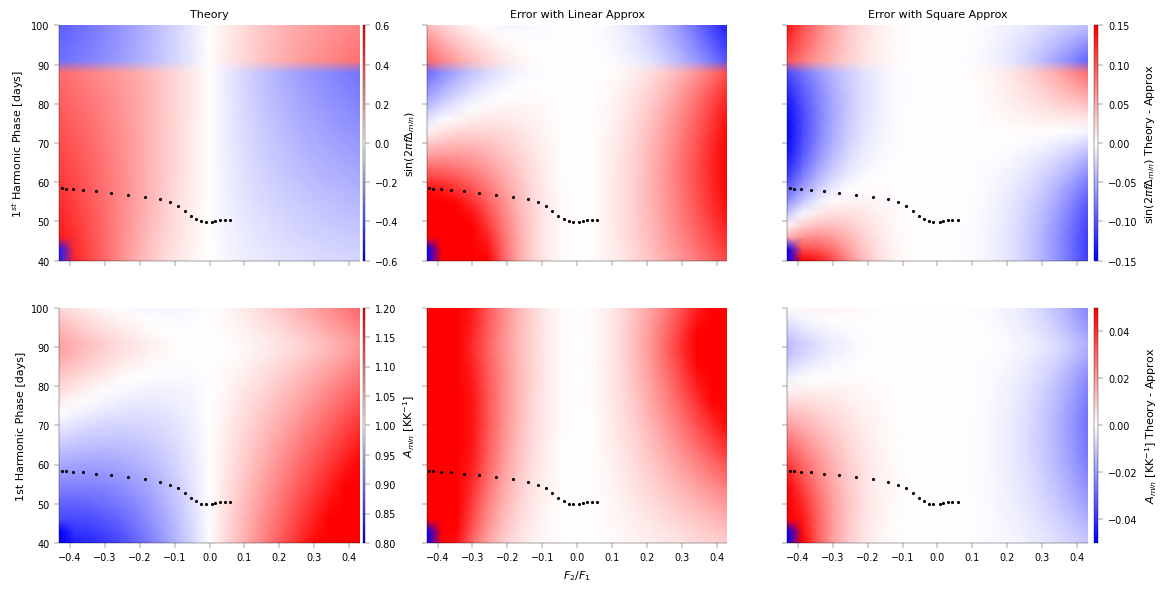

In [28]:
plot_extrema_ind=0
key = 'square_phase_fourier'

fig, ax = plt.subplots(2, 3, figsize=(3*im_sz*width['one_col'], 2*im_sz*width['one_col']/ar), sharex=True, sharey=True)
im = ax[0, 0].pcolormesh(plot_range_val['sw'], plot_range_val['date_first_harmonic'],
                         extrema_time_range['sw_heat_capacity'][plot_extrema_ind].transpose(),
                    vmin=-0.6, vmax=0.6, cmap='bwr', shading='gouraud')
fig.colorbar(im, ax=ax[0, 0], label='$\sin(2\pi f \Delta_{min})$' if plot_extrema_ind==0 else '$\sin(2\pi f \Delta_{max})$',
             aspect=100, pad=0.01, fraction=0.01)
im = ax[1, 0].pcolormesh(plot_range_val['sw'], plot_range_val['date_first_harmonic'],
                         extrema_amp_range['sw_heat_capacity'][plot_extrema_ind].transpose(),
                    vmin=0.8, vmax=1.2, cmap='bwr', shading='gouraud')
fig.colorbar(im, ax=ax[1, 0], label='$A_{min}$ [KK$^{-1}$]' if plot_extrema_ind==0 else '$A_{max}$ [KK$^{-1}$]',
             aspect=100, pad=0.01, fraction=0.01)
ax[0, 0].set_title('Theory')
for i, key2 in enumerate(['linear', 'square']):
    im = ax[0, 1+i].pcolormesh(plot_range_val['sw'], plot_range_val['date_first_harmonic'],
                             (extrema_time_range['sw_heat_capacity'][plot_extrema_ind] -
                              extrema_time_range[f'sw_heat_capacity_approx_{key2}'][plot_extrema_ind]).transpose(),
                        vmin=-0.15, vmax=0.15, cmap='bwr', shading='gouraud')
    im2 = ax[1, 1+i].pcolormesh(plot_range_val['sw'], plot_range_val['date_first_harmonic'],
                             (extrema_amp_range['sw_heat_capacity'][plot_extrema_ind] -
                              extrema_amp_range[f'sw_heat_capacity_approx_{key2}'][plot_extrema_ind]).transpose(),
                        vmin=-0.05, vmax=0.05, cmap='bwr', shading='gouraud')
    ax[0, 1+i].set_title('Error with ' + key2.capitalize() + ' Approx')
fig.colorbar(im, ax=ax[0, 1:].ravel().tolist(),
             label=('$\sin(2\pi f \Delta_{min})$' if plot_extrema_ind==0 else '$\sin(2\pi f \Delta_{max})$') + ' Theory - Approx',
             aspect=60, pad=0.01, fraction=0.01)
fig.colorbar(im2, ax=ax[1, 1:].ravel().tolist(),
             label=('$A_{min}$ [KK$^{-1}$]' if plot_extrema_ind==0 else '$A_{max}$ [KK$^{-1}$]') + ' Theory - Approx',
             aspect=60, pad=0.01, fraction=0.01)
for ax_use in ax.flatten():
    ax_use.scatter(sw_amp_coefs['2_harmonic'][:, 2]/sw_amp_coefs['2_harmonic'][:, 1],
                   date_from_heat_capacity(heat_capacity, gamma_params[key][:, 4]), color='k', marker='.', label='Aquaplanet')
    # ax_use.scatter(sw_amp_coefs['2_harmonic'][:, 2]/sw_amp_coefs['2_harmonic'][:, 1],
    #                date_land_scatter, color='k', marker='+', s=2, label='Land')
# ax[0, 0].legend()
# date_land_scatter = date_from_heat_capacity(heat_capacity, gamma_params[key][:, 4])
ax[1, 1].set_xlabel('$F_2/F_1$')
ax[0, 0].set_ylabel('1$^{st}$ Harmonic Phase [days]')
ax[1, 0].set_ylabel('1st Harmonic Phase [days]')
plt.show()

### Non-linear $F_2/F_1$ Terms
From the above, it is clear that $F_2/F_1$ is the parameter that causes the greatest variation with latitude. So below, we see how the co-variation of each parameter along with $F_2/F_1$ influence the extrema.

The error in the taylor series non-linear term and the full theory value is shown to be large for the $F_2\lambda_{sq}$ non-linear term at large negative $F_2/F_1$. This is much more the case for timing than amplitude.

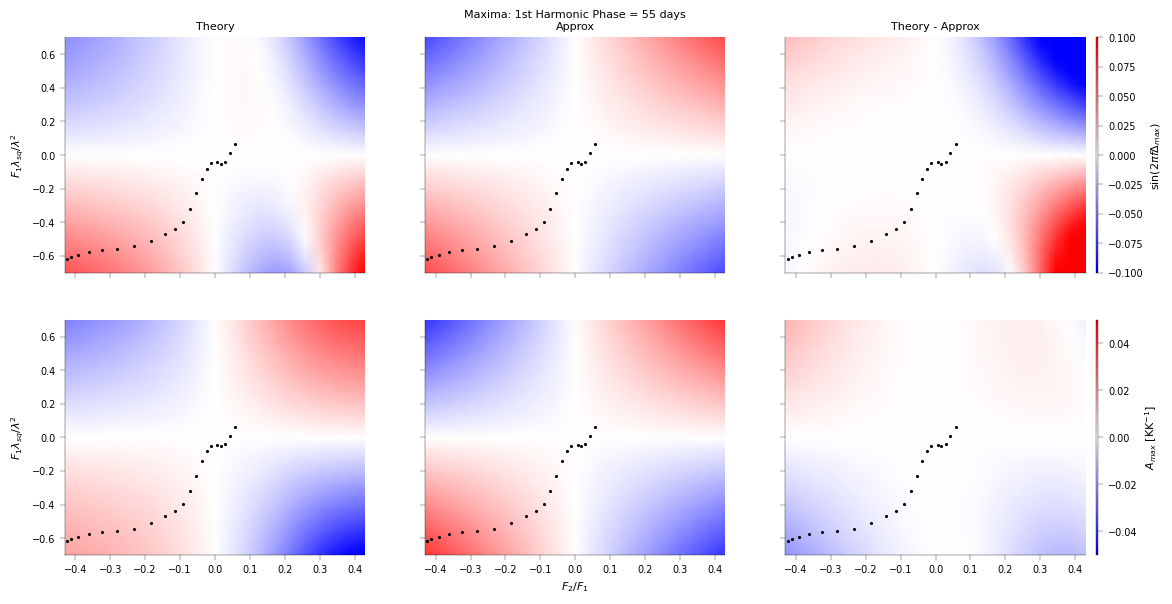

In [29]:
plot_extrema_ind=1
key = 'square_phase_fourier'

ax_lims_timing_error = 0.1
ax_lims_amp_error = 0.05
# ax_lims_timing_error = 0.01
# ax_lims_amp_error = 0.01
# Timing
fig, ax = plt.subplots(2, 3, figsize=(3*im_sz*width['one_col'], 2*im_sz*width['one_col']/ar), sharex=True, sharey=True)
ax[0, 0].pcolormesh(plot_range_val[non_linear_var1], plot_range_val[non_linear_var2],
                         extrema_time_range['non_linear'][plot_extrema_ind].transpose(),
                    vmin=-ax_lims_timing_error, vmax=ax_lims_timing_error,
                         cmap='bwr', shading='gouraud')
ax[0, 0].set_title('Theory')
ax[0, 1].pcolormesh(plot_range_val[non_linear_var1], plot_range_val[non_linear_var2],
                         extrema_time_range['non_linear_approx'][plot_extrema_ind].transpose(),
                    vmin=-ax_lims_timing_error, vmax=ax_lims_timing_error,
                         cmap='bwr', shading='gouraud')
ax[0, 1].set_title("{}: 1st Harmonic Phase = {:.0f} days\nApprox".format(plot_extrema_label[plot_extrema_ind], date_from_heat_capacity(plot_const_val['heat_capacity'],
                                                                                             plot_const_val['lambda'])))
im = ax[0, 2].pcolormesh(plot_range_val[non_linear_var1], plot_range_val[non_linear_var2],
                         (extrema_time_range['non_linear'] - extrema_time_range['non_linear_approx'])[plot_extrema_ind].transpose(),
                    vmin=-ax_lims_timing_error, vmax=ax_lims_timing_error,
                         cmap='bwr', shading='gouraud')
ax[0, 2].set_title('Theory - Approx')
fig.colorbar(im, ax=ax[0].ravel().tolist(), label='$\sin(2\pi f \Delta_{min})$' if plot_extrema_ind==0 else '$\sin(2\pi f \Delta_{max})$',
             aspect=100, pad=0.01, fraction=0.01)

# Amplitude
ax[1, 0].pcolormesh(plot_range_val[non_linear_var1], plot_range_val[non_linear_var2],
                         extrema_amp_range['non_linear'][plot_extrema_ind].transpose(),
                    vmin=-ax_lims_amp_error, vmax=ax_lims_amp_error,
                         cmap='bwr', shading='gouraud')
ax[1, 1].pcolormesh(plot_range_val[non_linear_var1], plot_range_val[non_linear_var2],
                         extrema_amp_range['non_linear_approx'][plot_extrema_ind].transpose(),
                    vmin=-ax_lims_amp_error, vmax=ax_lims_amp_error,
                         cmap='bwr', shading='gouraud')
im = ax[1, 2].pcolormesh(plot_range_val[non_linear_var1], plot_range_val[non_linear_var2],
                         (extrema_amp_range['non_linear'] - extrema_amp_range['non_linear_approx'])[plot_extrema_ind].transpose(),
                    vmin=-ax_lims_amp_error, vmax=ax_lims_amp_error,
                         cmap='bwr', shading='gouraud')
fig.colorbar(im, ax=ax[1].ravel().tolist(), label='$A_{min}$ [KK$^{-1}$]' if plot_extrema_ind==0 else '$A_{max}$ [KK$^{-1}$]',
             aspect=100, pad=0.01, fraction=0.01)

if non_linear_var1=='sw':
    for ax_use in ax.flatten():
        if non_linear_var2=='sq':
            ax_use.scatter(sw_amp_coefs['2_harmonic'][:, 2]/sw_amp_coefs['2_harmonic'][:, 1],
                           sw_amp_coefs['2_harmonic'][:, 1]*gamma_params[key][:, 3]/gamma_params[key][:, 4]**2, color='k', marker='.')
        if non_linear_var2=='phase':
            ax_use.scatter(sw_amp_coefs['2_harmonic'][:, 2]/sw_amp_coefs['2_harmonic'][:, 1],
                           gamma_params[key][:, 2]/gamma_params[key][:, 4], color='k', marker='.')
ax[1, 1].set_xlabel(labels_param[non_linear_var1])
ax[0, 0].set_ylabel(labels_param[non_linear_var2])
ax[1, 0].set_ylabel(labels_param[non_linear_var2])
plt.show()

### Sensitivity Parameters
The taylor series approximation for the hottest day of the year can be written as:

$y = \gamma_F(x)\frac{F_2}{F_1} + \gamma_{phase}(x) \frac{\lambda_{phase}}{\lambda} + \gamma_{sq}(x) \frac{F_1\lambda_{sq}}{\lambda^2} +
\gamma_{cos}(x)\frac{\Lambda_{cos}}{F_1} + \gamma_{sin}(x)\frac{\Lambda_{sin}}{F_1}$

plus non-linear and square terms, where $x=2\pi fC/\lambda$. We plot the variation of the sensitivity $\gamma$ parameters below. We also do a similar thing for the amplitude.

In [30]:
sensitivity_params_timing = {key: np.zeros((2, n_range_val)) for key in ['sw', 'phase', 'sq', 'sin', 'sw_square', 'phase_square', 'sw_phase',
                                                                         'sw_sq', 'sw_sin']}
sensitivity_params_amp = {key: np.zeros((2, n_range_val)) for key in sensitivity_params_timing}
for k in range(2):
    for i in range(n_range_val):
            var = \
                get_extrema_theory_approx(ds.time.to_numpy(), plot_const_val['F_1'],
                                   plot_const_val['F_1'] * plot_range_val['sw'][i],
                                   heat_capacity_from_date(plot_range_val['date_first_harmonic'][i], plot_const_val['lambda']),
                                   plot_const_val['lambda'], 0, 0, 0, 0, harmonic_extrema_ind=k+1)[3::2]
            for key2 in sensitivity_params_timing:
                sensitivity_params_timing[key2][k, i] = var[0][key2]
                sensitivity_params_amp[key2][k, i] = var[1][key2]

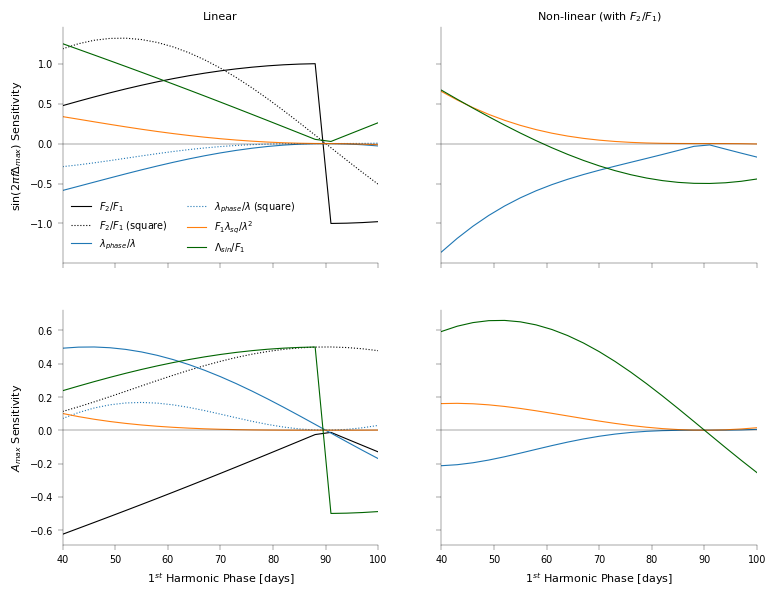

In [31]:
plot_extrema_ind = 1
fig, ax = plt.subplots(2, 2, figsize=(2*im_sz*width['one_col'], 2*im_sz*width['one_col']/ar), sharex=True, sharey='row')
for key2 in ['sw', 'phase', 'sq', 'sin']:
    ax[0, 0].plot(plot_range_val['date_first_harmonic'], sensitivity_params_timing[key2][plot_extrema_ind], color=color_param[key2],
                  label=labels_param[key2])
    ax[1, 0].plot(plot_range_val['date_first_harmonic'], sensitivity_params_amp[key2][plot_extrema_ind], color=color_param[key2])
    if key2 in ['sw', 'phase']:
        ax[0, 0].plot(plot_range_val['date_first_harmonic'], sensitivity_params_timing[key2+'_square'][plot_extrema_ind],
                      color=color_param[key2], linestyle=':', label=labels_param[key2] + ' (square)')
        ax[1, 0].plot(plot_range_val['date_first_harmonic'], sensitivity_params_amp[key2+'_square'][plot_extrema_ind],
                      color=color_param[key2], linestyle=':')
    if key2 != 'sw':
        ax[0, 1].plot(plot_range_val['date_first_harmonic'], sensitivity_params_timing['sw_'+key2][plot_extrema_ind],
                      color=color_param[key2])
        ax[1, 1].plot(plot_range_val['date_first_harmonic'], sensitivity_params_amp['sw_'+key2][plot_extrema_ind],
                      color=color_param[key2])
ax[0, 0].set_xlim(plot_range_val['date_first_harmonic'][0], plot_range_val['date_first_harmonic'][-1])
ax[1, 0].set_xlabel('1$^{st}$ Harmonic Phase [days]')
ax[1, 1].set_xlabel('1$^{st}$ Harmonic Phase [days]')
ax[0, 0].set_ylabel(f'$\sin(2\pi f\Delta_{"{"+plot_extrema_label[plot_extrema_ind].lower()[:3]+"})"}$ Sensitivity')
ax[1, 0].set_ylabel(f'$A_{"{"+plot_extrema_label[plot_extrema_ind].lower()[:3]+"}"}$ Sensitivity')
ax[0, 0].legend(ncol=2)
ax[0, 0].set_title('Linear')
ax[0, 1].set_title('Non-linear (with $F_2/F_1$)')
for ax_use in ax.flatten():
    ax_use.axhline(0, color='k', lw=ax_linewidth)
plt.show()

### Breaking down deviation of extrema from 1st harmonic at each latitude

Below I break down the cause for deviation of extrema from what you would expect at a given latitude, if $F_2=\lambda_{phase}=\lambda_{sq}=\Lambda_{sin}=\Lambda_{cos}=0$.

I plot the taylor series approximation for each term in the middle column.

In the right column, I plot the residual which is the theoretical contribution of each parameter/s minus the taylor approximation. For a single parameter e.g. $\lambda_{phase}$ at latitude $\phi$, this is (unlisted variables in $y_{theory}$ are set to 0):
$y_{theory}(F_1(\phi), \lambda(\phi), \lambda_{phase}(\phi)) - \gamma_{phase}\frac{\lambda_{phase}}{\lambda}(\phi) - \gamma_{phase^2}(\frac{\lambda_{phase}}{\lambda}(\phi))^2$

For non-linear terms e.g. due to $F_2/F_1$ and $\lambda_{phase}$, the residual is calculated as:
$y_{theory}(F_1(\phi), \lambda(\phi), \frac{F_2}{F_1}(\phi), \lambda_{phase}(\phi)) -
y_{theory}(F_1(\phi), \lambda(\phi), \frac{F_2}{F_1}(\phi)) - y_{theory}(F_1(\phi), \lambda(\phi), \lambda_{phase}(\phi)) -
\gamma_{F,phase}\frac{F_2}{F_1}(\phi)\frac{\lambda_{phase}}{\lambda}(\phi)$

Just considering linear and square terms does a decent job, and gives a good indication of what causes the deviation at each latitude. But at high latitudes, the residual due to $F_2/F_1$ is large.

In [32]:
key = 'square_phase_fourier'
extrema_time_lat_breakdown = {key2: np.zeros((2, n_lat)) for key2 in
                                     ['sw', 'phase', 'sq', 'cos', 'sin', 'sw_square', 'phase_square', 'sq_square', 'cos_square', 'sin_square',
                                      'sw_residual', 'phase_residual', 'sq_residual', 'cos_residual', 'sin_residual',
                                      'sw_phase', 'sw_sq', 'sw_cos', 'sw_sin',
                                      'sw_phase_residual', 'sw_sq_residual', 'sw_cos_residual', 'sw_sin_residual', 'residual']}
extrema_amp_lat_breakdown = {key2: np.zeros((2, n_lat)) for key2 in extrema_time_lat_breakdown}

for i in range(n_lat):
    for k in range(2):
        var = get_extrema_theory_approx(ds.time.to_numpy(), sw_amp_coefs['2_harmonic'][i, 1], sw_amp_coefs['2_harmonic'][i, 2], heat_capacity,
                                        gamma_params[key][i, 4], gamma_params[key][i, 2], gamma_params[key][i, 3], gamma_params[key][i, 0],
                                        gamma_params[key][i, 1], harmonic_extrema_ind=k+1)[4::2]
        for key2 in var[0]:
            extrema_time_lat_breakdown[key2][k, i] = var[0][key2]
            extrema_amp_lat_breakdown[key2][k, i] = var[1][key2]
        var = {}

        # Get residual of non-linear terms by considering full theory with no approx.
        # Take full non-linear term and subtract each of the two linear terms
        for key2 in ['sw', 'phase', 'sq', 'cos', 'sin']:
            var[key2] = get_extrema_theory(ds.time.to_numpy(), sw_amp_coefs['2_harmonic'][i, 1],
                                             sw_amp_coefs['2_harmonic'][i, 2] if 'sw' in key2 else
                                             plot_const_val['sw'] * sw_amp_coefs['2_harmonic'][i, 1], heat_capacity, gamma_params[key][i, 4],
                                             gamma_params[key][i, 2] if 'phase' in key2 else plot_const_val['phase'],
                                             gamma_params[key][i, 3] if 'sq' in key2 else plot_const_val['sq'],
                                             gamma_params[key][i, 0] if 'cos' in key2 else plot_const_val['cos'],
                                             gamma_params[key][i, 1] if 'sin' in key2 else plot_const_val['sin'], harmonic_extrema_ind=k+1)[:2]
            # Residual is no approx - linear term of approx - square term of approx
            extrema_time_lat_breakdown[f'{key2}_residual'][k, i] = var[key2][0] - extrema_time_lat_breakdown[key2][k, i] - \
                                                          extrema_time_lat_breakdown[f'{key2}_square'][k, i]
            extrema_amp_lat_breakdown[f'{key2}_residual'][k, i] = (var[key2][1]-1) - extrema_amp_lat_breakdown[key2][k, i] -\
                                                                  extrema_amp_lat_breakdown[f'{key2}_square'][k, i]
            if key2 != 'sw':
                var[f'sw_{key2}'] = get_extrema_theory(ds.time.to_numpy(), sw_amp_coefs['2_harmonic'][i, 1],
                                                 sw_amp_coefs['2_harmonic'][i, 2], heat_capacity, gamma_params[key][i, 4],
                                                 gamma_params[key][i, 2] if 'phase' in key2 else plot_const_val['phase'],
                                                 gamma_params[key][i, 3] if 'sq' in key2 else plot_const_val['sq'],
                                                 gamma_params[key][i, 0] if 'cos' in key2 else plot_const_val['cos'],
                                                 gamma_params[key][i, 1] if 'sin' in key2 else plot_const_val['sin'], harmonic_extrema_ind=k+1)[:2]
                # No approx non-linear term equals var with 2 variables changed minus var with one variable changed minus var with
                # other variable changed. Then to get residual, subtract approximate taylor series estimate of non-linear term.
                extrema_time_lat_breakdown[f'sw_{key2}_residual'][k, i] = var[f'sw_{key2}'][0] - var['sw'][0] - var[key2][0] - \
                    extrema_time_lat_breakdown[f'sw_{key2}'][k, i]
                extrema_amp_lat_breakdown[f'sw_{key2}_residual'][k, i] = (var[f'sw_{key2}'][1]-1) - (var['sw'][1]-1) - (var[key2][1]-1) - \
                    extrema_amp_lat_breakdown[f'sw_{key2}'][k, i]
        for key2 in extrema_time_lat_breakdown:
            # Residual is due to non-linear contributions of 3 or more variables changing. Find by subtracting full theory
            # from sum of all terms in dict.
            if key2 == 'residual':
                extrema_time_lat_breakdown['residual'][k, i] += y_extrema[key]['theory_full'][i, k]
                extrema_amp_lat_breakdown['residual'][k, i] += amp_scale_extrema[key]['theory_full'][i, k] - 1
            else:
                extrema_time_lat_breakdown['residual'][k, i] -= extrema_time_lat_breakdown[key2][k, i]
                extrema_amp_lat_breakdown['residual'][k, i] -= extrema_amp_lat_breakdown[key2][k, i]

In [33]:
# Sum up all approximation terms to get various approximations to the theory
# Time
var = {key: extrema_time_lat_breakdown[key] for key in extrema_time_lat_breakdown if
       ('residual' not in key) and ('sw_' not in key) and ('square' not in key)}
extrema_time_lat_breakdown['linear_sum'] = np.asarray([sum(var) for var in zip(*var.values())])
var = {key: extrema_time_lat_breakdown[key] for key in extrema_time_lat_breakdown if
       'square' in key}
extrema_time_lat_breakdown['square_sum'] = np.asarray([sum(var) for var in zip(*var.values())])
var = {key: extrema_time_lat_breakdown[key] for key in extrema_time_lat_breakdown if
       ('residual' not in key) and ('sw_' in key) and ('square' not in key)}
extrema_time_lat_breakdown['non_linear_sum'] = np.asarray([sum(var) for var in zip(*var.values())])

# Amplitude
var = {key: extrema_amp_lat_breakdown[key] for key in extrema_amp_lat_breakdown if
       ('residual' not in key) and ('sw_' not in key) and ('square' not in key)}
extrema_amp_lat_breakdown['linear_sum'] = np.asarray([sum(var) for var in zip(*var.values())])
var = {key: extrema_amp_lat_breakdown[key] for key in extrema_amp_lat_breakdown if
       'square' in key}
extrema_amp_lat_breakdown['square_sum'] = np.asarray([sum(var) for var in zip(*var.values())])
var = {key: extrema_amp_lat_breakdown[key] for key in extrema_amp_lat_breakdown if
       ('residual' not in key) and ('sw_' in key) and ('square' not in key)}
extrema_amp_lat_breakdown['non_linear_sum'] = np.asarray([sum(var) for var in zip(*var.values())])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


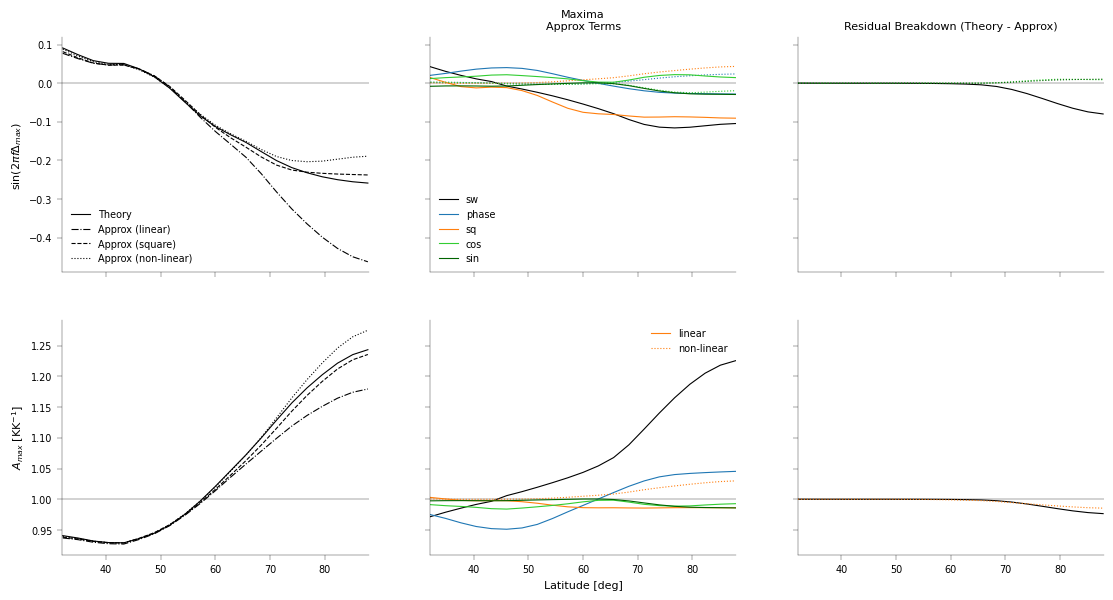

In [34]:
plot_extrema_ind = 1
fig, ax = plt.subplots(2, 3, figsize=(3*im_sz*width['one_col'], 2*im_sz*width['one_col']/ar), sharex=True, sharey='row')
thresh_plot = 0.01   # only plot term if larger than this
var0 = [0, 1]

ax[0, 0].plot(ds.lat, y_extrema[key]['theory_full'][:, plot_extrema_ind], color='k', label='Theory')
ax[1, 0].plot(ds.lat, amp_scale_extrema[key]['theory_full'][:, plot_extrema_ind], color='k')
for i, var in enumerate([extrema_time_lat_breakdown, extrema_amp_lat_breakdown]):
    for ax_use in ax[i]:
        ax_use.axhline(var0[i], color='k', lw=ax_linewidth)
    ax[i, 0].plot(ds.lat, var0[i]+var['linear_sum'][plot_extrema_ind], color='k', linestyle='-.', label='Approx (linear)')
    ax[i, 0].plot(ds.lat, var0[i]+var['linear_sum'][plot_extrema_ind] + var['square_sum'][plot_extrema_ind], color='k', linestyle='--',
                  label='Approx (square)')
    ax[i, 0].plot(ds.lat, var0[i]+var['linear_sum'][plot_extrema_ind] + var['square_sum'][plot_extrema_ind] +
                  var['non_linear_sum'][plot_extrema_ind], color='k', linestyle=':', label='Approx (non-linear)')
    if np.max(np.abs(var['residual'][plot_extrema_ind])) > thresh_plot:
        ax[i, 2].plot(ds.lat, var0[i]+var['residual'][plot_extrema_ind], color='r', linestyle='--', label='$\geq 3$ variable terms')
    for key2 in ['sw', 'phase', 'sq', 'cos', 'sin']:
        ax[i, 1].plot(ds.lat, var0[i]+var[key2][plot_extrema_ind]+var[f'{key2}_square'][plot_extrema_ind],
                      color=color_param[key2], label=key2 if i==0 else ('linear' if key2=='sq' else None))
        if np.max(np.abs(var[f'{key2}_residual'][plot_extrema_ind])) > thresh_plot:
            ax[i, 2].plot(ds.lat, var0[i]+var[f'{key2}_residual'][plot_extrema_ind], color=color_param[key2])
        if key2 != 'sw':
            if np.max(np.abs(var[f'sw_{key2}'][plot_extrema_ind])) > thresh_plot:
                ax[i, 1].plot(ds.lat, var0[i]+var[f'sw_{key2}'][plot_extrema_ind], color=color_param[key2], linestyle=':',
                label=None if i==0 else ('non-linear' if key2=='sq' else None))
            if np.max(np.abs(var[f'sw_{key2}_residual'][plot_extrema_ind])) > thresh_plot:
                ax[i, 2].plot(ds.lat, var0[i]+var[f'sw_{key2}_residual'][plot_extrema_ind], color=color_param[key2], linestyle=':')
ax[0, 0].set_xlim(ax_lims_lat)
ax[0, 0].set_ylabel(f'$\sin(2\pi f \Delta_{"{"+plot_extrema_label[plot_extrema_ind][:3].lower()+"}"})$')
ax[1, 0].set_ylabel(f'$A_{"{"+plot_extrema_label[plot_extrema_ind][:3].lower()+"}"}$'+' [KK$^{-1}$]')
ax[0, 0].legend()
ax[0, 1].legend()
ax[1, 1].legend()
ax[0, 2].legend()
ax[1, 1].set_xlabel('Latitude [deg]')
ax[0, 1].set_title(plot_extrema_label[plot_extrema_ind]+'\nApprox Terms')
ax[0, 2].set_title('Residual Breakdown (Theory - Approx)')
plt.show()

### Insight into effect of $\Gamma$ parameters
The surface energy budget is of the form: $C\frac{\partial T}{\partial t} = F(t) - \Gamma(T, t)$.

Thus, if we say $T_1(t)$ is the 1st harmonic element of the solution to this, $(F(t) - \Gamma(T_1(t), t))/C$, gives an indication of $\partial T/\partial t$, and thus gives information about the extrema.

Below we look at how each variable influences $(F(t) - \Gamma(T_1(t), t))/C$.

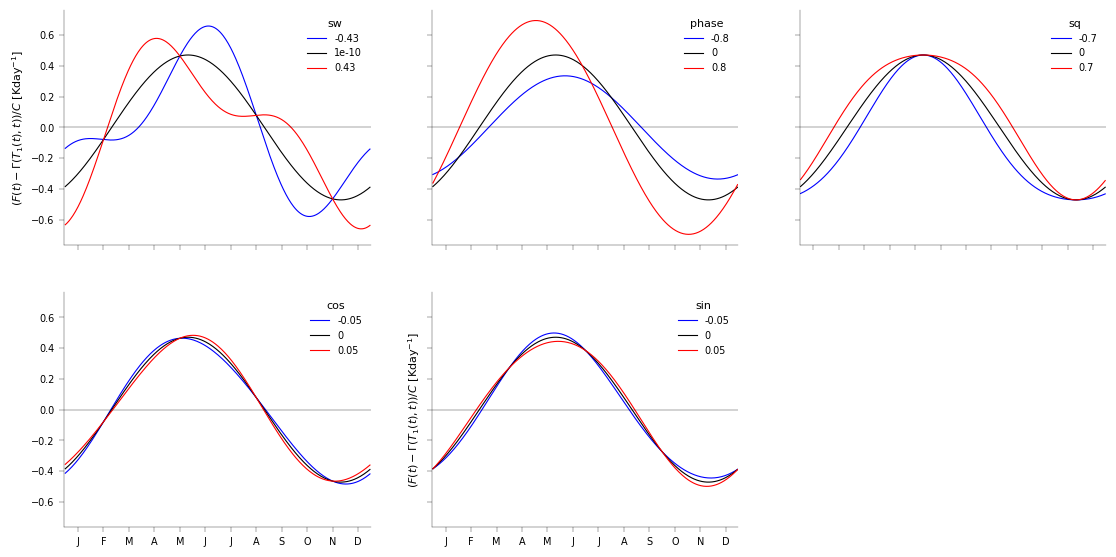

In [35]:
sw_schematic_param = [300, plot_const_val['F_1'], 0]
gamma_schematic_param = [plot_const_val['cos'], plot_const_val['sin'], plot_const_val['phase'],
                         plot_const_val['sq'], plot_const_val['lambda'], sw_schematic_param[0]/2]
gamma_param_ind = {'cos': 0, 'sin': 1, 'phase': 2, 'sq': 3, 'lambda': 4}
gamma_param_prefactor = {'cos': plot_const_val['F_1'], 'sin': plot_const_val['F_1'], 'sq': 1/(plot_const_val['F_1']/plot_const_val['lambda']**2),
                         'phase': plot_const_val['lambda']}
color_use = ['b', 'k', 'r']
fig, ax = plt.subplots(2, 3, figsize=(3*im_sz*width['one_col'], 2*im_sz*width['one_col']/ar), sharex=True, sharey=True)
ax = ax.flatten()
for i, key2 in enumerate(['sw', 'phase', 'sq', 'cos', 'sin']):
    for j, var in enumerate([plot_range_val[key2][0], plot_const_val[key2], plot_range_val[key2][-1]]):
        if key2 == 'sw':
            sw_schematic = fourier.fourier_series(ds.time, [sw_schematic_param[0], sw_schematic_param[1], var*sw_schematic_param[1]], [0, 0])
            temp_schematic = get_temp_fourier_analytic(ds.time,sw_schematic, heat_capacity, plot_const_val['lambda'], n_harmonics_sw=1)[0].to_numpy()
        elif key2 == 'phase':
            sw_schematic = fourier.fourier_series(ds.time, sw_schematic_param, [0, 0])
            temp_schematic = get_temp_fourier_analytic(ds.time,sw_schematic, heat_capacity, plot_const_val['lambda'],
                                                       lambda_phase=var*gamma_param_prefactor[key2], n_harmonics_sw=1)[0].to_numpy()
        else:
            sw_schematic = fourier.fourier_series(ds.time, sw_schematic_param, [0, 0])
            temp_schematic = get_temp_fourier_analytic(ds.time,sw_schematic, heat_capacity, plot_const_val['lambda'], n_harmonics_sw=1)[0].to_numpy()
        gamma_schematic_param_use = copy.deepcopy(gamma_schematic_param)
        if 'sw' not in key2:
            gamma_schematic_param_use[gamma_param_ind[key2]] = var
        gamma_schematic_param_use[0] = gamma_schematic_param_use[0] * gamma_param_prefactor['cos']
        gamma_schematic_param_use[1] = gamma_schematic_param_use[1] * gamma_param_prefactor['sin']
        gamma_schematic_param_use[2] = gamma_schematic_param_use[2] * gamma_param_prefactor['phase']
        gamma_schematic_param_use[3] = gamma_schematic_param_use[3] * gamma_param_prefactor['sq']
        var2 = fourier.coef_conversion(cos_coef=gamma_schematic_param_use[0], sin_coef=gamma_schematic_param_use[1])
        var2 = numerical.polyval_phase(gamma_schematic_param_use[2:], temp_schematic,
                                       coefs_fourier_amp=[0, 0, var2[0]], coefs_fourier_phase=[0, var2[1]])
        ax[i].plot((sw_schematic - var2)/heat_capacity * 86400, color=color_use[j], label=var)
        ax[i].legend(title=key2)
    ax[i].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_xlim(-1, 360)
ax[-1].axis('off')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('$(F(t) - \Gamma(T_1(t), t))/C$ [Kday$^{-1}$]')
ax[4].set_ylabel('$(F(t) - \Gamma(T_1(t), t))/C$ [Kday$^{-1}$]')
plt.show()